**Recommender System: Multi-Model Introduction:**

This script trains a sequential recommender system on a **user-specified/customizable** MovieLens dataset (100K, 1M, 10M, or 20M).

It preprocesses the data, maps user/item IDs, and splits interactions into train/validation/test sequences.

Users can select among four models: **standard LSTM, xLSTM, BERT4REC, SAS4REC** variant with configurable parameters.

The selected model is trained using PyTorch with evaluation metrics like Recall@10, MRR, Hit Rate and NDCG.

After training, the best model is used to predict and display top-10 movie recommendations based on user history.

**Training script that integrates:**

A. Dynamic dataset selection (100K, 1M, 10M, 20M)

B. Multiple model choices (LSTM, xLSTM, BERT4Rec, SASRec)

C. Dataset-specific hyperparameters (xlstm_params, dataloader_params)

D. TensorBoard logging

E. GPU monitoring

F. Evaluation metrics (Recall@10, MRR, NDCG)

G. Early stopping + best model saving

H. Easy-readable prediction logging with movie titles


**Few Research Focus Areas/Questions:**
1. Embedding Saturation and Utilization: Are larger embeddings really helping the model learn better user/item relationships, or are they underutilized?
2. Gradient Stability / Exploding Gradients: Do longer sequences introduce more instability or gradient explosion?
3. Computation-Time vs Performance Trade-off: At what point does longer sequence input hurt speed more than it helps accuracy?
4. Effective Sequence Length vs. Truncation: How much of the input sequence is actually contributing to predictions?
5. Overfitting Signals: Do longer sequences encourage memorization rather than generalization?
6. Top-k Diversity / Coverage: Does sequence length affect recommendation diversity or item popularity bias?
7. Token Usage Heatmap: Where in the sequence is the model focusing? More recent items or early ones?
8. Ablation Logging: How much performance drop occurs when certain features are turned off?

# Initial Setup Requirements

A. Install Necessary Packages (in quite mode)

B. Triton Activation For GPU Acceleration (To make sure Triton and GPU Accerleration, to speed up the training process)

C. Select the necessary model and datasets (Model)

D. Run all would work, to change the model and datasets, please adjust the variable in the main script.

E. Script is mainly desinged for Colab Environment, for A100 GPU. Single click solution.

In [9]:
# Check the latest Python Version, not needed everytime but to ensure if any updates
import json
import urllib.request

def get_latest_version(package_name):
    url = f"https://pypi.org/pypi/{package_name}/json"
    with urllib.request.urlopen(url) as r:
        data = json.load(r)
    return data["info"]["version"]

packages = ["mlstm_kernels", "xlstm", "torch", "torchvision", "torchaudio"]
for pkg in packages:
    print(f"{pkg}: {get_latest_version(pkg)}")

mlstm_kernels: 2.0.1
xlstm: 2.0.5
torch: 2.8.0
torchvision: 0.23.0
torchaudio: 2.8.0


In [10]:
import random, numpy as np, torch, subprocess


# List of packages with exact versions
pkgs = [
    "mlstm_kernels==2.0.0",
    "xlstm==2.0.4",
    "torch==2.7.1",
    "torchvision==0.22.1",
    "torchaudio==2.7.1"
]

# Install with CUDA 12.1 index URL and no output
subprocess.run([
    "pip", "install", "--upgrade", *pkgs,
    "--index-url", "https://download.pytorch.org/whl/cu121"
], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

print("Installed: mlstm_kernels==2.0.0, xlstm==2.0.4, torch==2.7.1, torchvision==0.22.1, torchaudio==2.7.1")



Installed: mlstm_kernels==2.0.0, xlstm==2.0.4, torch==2.7.1, torchvision==0.22.1, torchaudio==2.7.1


In [11]:
# #  Install model kernel dependencies
# !pip install -q mlstm_kernels==2.0.0 xlstm==2.0.4

# #  Install specific PyTorch + CUDA 12.1 compatible versions
# !pip install -q torch==2.7.1 torchvision==0.22.1 torchaudio==2.7.1 --index-url https://download.pytorch.org/whl/cu121

# print("[] Successfully Installed: mlstm_kernels==2.0.0, xlstm==2.0.4, torch==2.7.1, torchvision==0.22.1, torchaudio==2.7.1")

In [12]:
# PyTorch with Triton 3.1.0
# !pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [13]:
!pip install -q xlstm

In [14]:
!mkdir -p /usr/local/lib
!ln -sf /usr/lib64-nvidia/libcuda.so /usr/local/lib/libcuda.so

In [15]:
!find /usr -name "build.py" | grep triton

/usr/local/lib/python3.12/dist-packages/triton/runtime/build.py


In [16]:
#path = "/usr/local/lib/python3.11/dist-packages/triton/runtime/build.py"
path = "/usr/local/lib/python3.12/dist-packages/triton/runtime/build.py"


with open(path, "r") as f:
    lines = f.readlines()

patched_lines = []
for line in lines:
    if "dirs = [" in line:
        patched_lines.append('    dirs = ["/usr/lib64-nvidia", "/usr/local/lib"]  # patched\n')
    elif "assert any(os.path.exists(" in line:
        patched_lines.append('    # assertion disabled for libcuda.so\n')
    else:
        patched_lines.append(line)

with open(path, "w") as f:
    f.writelines(patched_lines)

print("GPU Check 1: Triton 3.1.0 patched for Colab CUDA.")


GPU Check 1: Triton 3.1.0 patched for Colab CUDA.


In [17]:
import os
os.environ["TRITON_DEBUG"] = "1"
os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/lib"
os.environ["LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/lib"
os.environ["PATH"] += ":/usr/local/lib"

import triton
import triton.language as tl
import torch

@triton.jit
def add_kernel(X_ptr, Y_ptr, Z_ptr, N: tl.constexpr):
    pid = tl.program_id(0)
    if pid >= N:
        return
    x = tl.load(X_ptr + pid)
    y = tl.load(Y_ptr + pid)
    tl.store(Z_ptr + pid, x + y)

# Test kernel
size = 1024
X = torch.rand(size, device='cuda')
Y = torch.rand(size, device='cuda')
Z = torch.empty(size, device='cuda')

add_kernel[(size,)](X, Y, Z, N=size)
print(" GPU Check 2: Triton 3.x kernel executed successfully!")
print(Z[:5])

 GPU Check 2: Triton 3.x kernel executed successfully!
tensor([1.6301, 1.0225, 1.2553, 0.9771, 0.6463], device='cuda:0')


In [18]:
#Just in case of Error:
# import os
# os.kill(os.getpid(), 9)

In [30]:
# Main Script
def recommender_main(model_name, seed, max_len):
    import os, sys, zipfile, requests, threading, subprocess, time, random, warnings
    import pandas as pd, numpy as np
    import torch, torch.nn as nn, torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    from torch.utils.tensorboard import SummaryWriter
    from tqdm import tqdm
    import matplotlib.pyplot as plt
    from xlstm.xlstm_large.model import xLSTMLargeConfig, xLSTMLarge

    warnings.filterwarnings("ignore")
    # global seed
    set_seed(seed)

    LEARNING_RATE = 1e-3

    os.environ["TRITON_DEBUG"] = "1"
    print("Output Section 1: Initialization")
    print("[INFO] Model initialized. Triton should log kernel compilation now.")

    # import os
    # # Required for Triton to run correctly in Colab
    # os.environ["TRITON_DEBUG"] = "1"
    os.environ["LD_LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/lib"
    os.environ["LIBRARY_PATH"] = "/usr/lib64-nvidia:/usr/local/lib"
    os.environ["PATH"] += ":/usr/local/lib"

    torch.cuda.empty_cache()
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
    print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Reserved : {torch.cuda.memory_reserved() / 1e9:.2f} GB")

    start_time = time.time()

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    import threading
    import subprocess
    import time

    gpu_utilization_log = []
    gpu_memory_log = []
    gpu_time_log = []


    def monitor_gpu(writer=None, interval=60):
        while True:
            output = subprocess.getoutput(
                "nvidia-smi --query-gpu=utilization.gpu,memory.used --format=csv,noheader,nounits"
            )
            util, mem = map(int, output.strip().split(','))
            elapsed = time.time() - start_time

            gpu_utilization_log.append(util)
            gpu_memory_log.append(mem)
            gpu_time_log.append(elapsed)

            print(f"[GPU MONITOR] {util}% GPU, {mem} MiB")

            # TensorBoard logging
            if writer:
                writer.add_scalar("GPU/Utilization(%)", util, global_step=int(elapsed))
                writer.add_scalar("GPU/Memory(MiB)", mem, global_step=int(elapsed))

            time.sleep(interval)


    # Start GPU monitor thread
    # monitor_thread = threading.Thread(target=monitor_gpu, daemon=True)
    # monitor_thread = threading.Thread(target=monitor_gpu, args=(120,), daemon=True)

    # monitor_thread.start()

    train_seqs = {}
    val_seqs = {}
    test_seqs = {}

    step_counter = 1
    logged_users = set()
    max_print_users = 5
    log_lines = []
    log_file_path = "training_logs.txt"


    sys.path.append("../..")


    # -----------------------------
    # 1. Select MovieLens Dataset
    # -----------------------------

    dataset_urls = {
        "100K": "https://files.grouplens.org/datasets/movielens/ml-100k.zip",
        "1M": "https://files.grouplens.org/datasets/movielens/ml-1m.zip",
        "10M": "https://files.grouplens.org/datasets/movielens/ml-10m.zip",
        "20M": "https://files.grouplens.org/datasets/movielens/ml-20m.zip",
        "AmazonE5": "https://mcauleylab.ucsd.edu/public_datasets/data/amazon_v2/categoryFiles/Software.json.gz"

    }

    # "AmazonE5": "https://mcauleylab.ucsd.edu/public_datasets/data/amazon_v2/categoryFiles/Electronics.json.gz"


    dataset_dirs = {
        "100K": "ml-100k",
        "1M": "ml-1m",
        "10M": "ml-10M100K",
        "20M": "ml-20m",
        "AmazonE5": "amazon-electronics-e5"

    }

    xlstm_params = {
        "100K": {"embedding_dim": 64, "num_heads": 2, "num_blocks": 1},
        "1M": {"embedding_dim": 128, "num_heads": 2, "num_blocks": 2},
        "10M": {"embedding_dim": 256, "num_heads": 8, "num_blocks": 4},
        "AmazonE5": {"embedding_dim": 128, "num_heads": 4, "num_blocks": 2},
        "20M": {"embedding_dim": 256, "num_heads": 8, "num_blocks": 4}
    }

    dataloader_params = {
        "100K": {"batch_size": 128, "num_workers": 2},
        "1M": {"batch_size": 128, "num_workers": 2},
        "10M": {"batch_size": 1024, "num_workers": 16},
        "AmazonE5": {"batch_size": 256, "num_workers": 4},
        "20M": {"batch_size": 1024, "num_workers": 16}
    }


    # ------------------------------
    # TensorBoard
    # ------------------------------
    params = xlstm_params[MOVIELENS_VERSION]  # dynamically get config

    #log_dir = f"runs/{MODEL_SELECTION}_{MOVIELENS_VERSION}_SL:{MAX_LEN}_Emb:{params['embedding_dim'_seed_{seed}]}"
    log_dir = f"runs/{model_name}_{MOVIELENS_VERSION}_SL:{MAX_LEN}_Emb:{params['embedding_dim']}_seed_{seed}"

    writer = SummaryWriter(log_dir=log_dir)

    monitor_thread = threading.Thread(target=monitor_gpu, args=(writer, 60), daemon=True)
    monitor_thread.start()


    DATA_URL = dataset_urls[MOVIELENS_VERSION]
    DATA_DIR = dataset_dirs[MOVIELENS_VERSION]

    # if not os.path.exists(DATA_DIR):
    #     print(f"Downloading MovieLens {MOVIELENS_VERSION} dataset...")
    #     r = requests.get(DATA_URL)
    #     zip_filename = f"{DATA_DIR}.zip"
    #     with open(zip_filename, "wb") as f:
    #         f.write(r.content)
    #     with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    #         zip_ref.extractall(".")
    #     print("Extraction complete.")


    # if not os.path.exists(DATA_DIR):
    #     print(f"Downloading {MOVIELENS_VERSION} dataset...")
    #     r = requests.get(DATA_URL)

    #     # Handle AmazonE5 separately (it's a .json.gz file)
    #     if MOVIELENS_VERSION == "AmazonE5":
    #         with open("Electronics.json.gz", "wb") as f:
    #             f.write(r.content)
    #         print("Download complete.")
    #     else:
    #         zip_filename = f"{DATA_DIR}.zip"
    #         with open(zip_filename, "wb") as f:
    #             f.write(r.content)
    #         with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    #             zip_ref.extractall(".")
    #         print("Extraction complete.")




    # -----------------------------
    # 2. Load and Preprocess Data
    # -----------------------------
    if MOVIELENS_VERSION == "100K":
        rating_df = pd.read_csv(os.path.join(DATA_DIR, "u.data"), sep="\t", engine='python',
                                names=['user_id', 'movie_id', 'rating', 'timestamp'])
        movies = pd.read_csv(os.path.join(DATA_DIR, "u.item"), sep='|', encoding='latin-1', header=None, engine='python',
                            names=['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
                                    'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                                    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                                    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
        users = pd.read_csv(os.path.join(DATA_DIR, "u.user"), sep='|', header=None,
                            names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

    elif MOVIELENS_VERSION == "1M":
        rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                                names=['user_id', 'movie_id', 'rating', 'timestamp'])
        movies = pd.read_csv(os.path.join(DATA_DIR, "movies.dat"), sep="::", engine='python',
                            names=['movie_id', 'title', 'genres'], encoding='latin-1')
        users = pd.read_csv(os.path.join(DATA_DIR, "users.dat"), sep="::", engine='python',
                            names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])

    elif MOVIELENS_VERSION == "10M":
        rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.dat"), sep="::", engine='python',
                                names=['user_id', 'movie_id', 'rating', 'timestamp'])
        movies = pd.read_csv(os.path.join(DATA_DIR, "movies.dat"), sep="::", engine='python',
                            names=['movie_id', 'title', 'genres'], encoding='latin-1')
        users = pd.DataFrame({'user_id': rating_df['user_id'].unique()})  # No user metadata

    elif MOVIELENS_VERSION == "AmazonE5":
        import os, json
        amazon_json = "Software.json"
        if not os.path.exists(amazon_json):
            raise FileNotFoundError(f"{amazon_json} not found. Upload or change path.")

        # Parse JSON Lines or a JSON array
        with open(amazon_json, "r", encoding="utf-8") as f:
            first = f.read(1); f.seek(0)
            rows = json.load(f) if first == "[" else [json.loads(l) for l in f if l.strip()]

        rating_df = pd.DataFrame(rows)[["reviewerID", "asin", "unixReviewTime"]].dropna()
        rating_df.rename(columns={"reviewerID":"user_id","asin":"movie_id","unixReviewTime":"timestamp"}, inplace=True)
        rating_df.sort_values(["user_id","timestamp"], inplace=True)

        users  = pd.DataFrame({"user_id":  rating_df["user_id"].unique()})
        movies = pd.DataFrame({"movie_id": rating_df["movie_id"].unique(),
                              "title":    rating_df["movie_id"].unique()})
        DATA_DIR = dataset_dirs[MOVIELENS_VERSION]

    elif MOVIELENS_VERSION == "20M":
        rating_df = pd.read_csv(os.path.join(DATA_DIR, "ratings.csv"))
        movies = pd.read_csv(os.path.join(DATA_DIR, "movies.csv"))
        users = pd.DataFrame({'user_id': rating_df['userId'].unique()})  # No user metadata

        rating_df.rename(columns={'userId': 'user_id', 'movieId': 'movie_id'}, inplace=True)
        movies.rename(columns={'movieId': 'movie_id'}, inplace=True)

    # -----------------------------
    # Map User and Item IDs
    # -----------------------------
    rating_df.sort_values(by=['user_id', 'timestamp'], inplace=True)
    user2id = {uid: i for i, uid in enumerate(rating_df['user_id'].unique())}
    item2id = {iid: i for i, iid in enumerate(rating_df['movie_id'].unique())}
    rating_df['user_id'] = rating_df['user_id'].map(user2id)
    rating_df['movie_id'] = rating_df['movie_id'].map(item2id)

    movie_titles = {item2id[row['movie_id']]: row['title'] for _, row in movies.iterrows() if row['movie_id'] in item2id}

    if 'user_id' in users.columns:
        users['user_id'] = users['user_id'].map(user2id)
        users.dropna(subset=['user_id'], inplace=True)
        users['user_id'] = users['user_id'].astype(int)

    if 'movie_id' in movies.columns:
        movies['movie_id'] = movies['movie_id'].map(item2id)
        movies.dropna(subset=['movie_id'], inplace=True)
        movies['movie_id'] = movies['movie_id'].astype(int)

    rating_df = rating_df.merge(users, on='user_id', how='left')
    rating_df = rating_df.merge(movies, on='movie_id', how='left')

    num_users = len(user2id)
    num_items = len(item2id)


    from collections import Counter

    # Compute item popularity from training data
    item_popularity = Counter(rating_df['movie_id'].tolist())

    # Sort items by frequency
    sorted_items = sorted(item_popularity.items(), key=lambda x: x[1], reverse=True)
    total_items = len(sorted_items)

    top_10_items = set([item for item, _ in sorted_items[:int(0.1 * total_items)]])
    mid_40_items = set([item for item, _ in sorted_items[int(0.1 * total_items):int(0.5 * total_items)]])
    bottom_50_items = set([item for item, _ in sorted_items[int(0.5 * total_items):]])


    print("-------------------------")
    print("Output Section 2: Important Parameters and Model Selection")

    print(f"Model: {MODEL_SELECTION}")
    print(f"Dataset: {MOVIELENS_VERSION}")
    print(f"Epoch: {EPOCHS}")
    print(f"MAX_LEN: {MAX_LEN}, LEARNING_RATE: {LEARNING_RATE}")


    #print(f"MAX_LEN: {MAX_LEN}, BATCH_SIZE: {batch_size}, LEARNING_RATE: {LEARNING_RATE}")
    print(f"Model Params ({MOVIELENS_VERSION}): {xlstm_params[MOVIELENS_VERSION]}")
    print(f"Dataloader Params ({MOVIELENS_VERSION}): {dataloader_params[MOVIELENS_VERSION]}")

    print(f"Length of ratings: {len(rating_df)}")
    print(f"Shape: {rating_df.shape}")
    print(f"Num users: {num_users}, Num items: {num_items}")

    print(f"Length of the ratings: {len(rating_df)}")
    print(f"Shape of the ratings dataframe: {rating_df.shape}")

    print("-------------------------")
    print("                  ")
    print("Output Section 3: Input Datasets For Reference")

    print(rating_df.head())
    # print(user2id)
    print(f"Number of unique users: {num_users}")
    print(f"Number of unique items: {num_items}")

    user_interactions = rating_df.groupby('user_id')['movie_id'].count()

    # Average sequence length (i.e., avg number of interactions per user)
    avg_seq_len = user_interactions.mean()

    # Sparsity calculation
    total_possible_interactions = num_users * num_items
    actual_interactions = len(rating_df)
    sparsity = 1.0 - (actual_interactions / total_possible_interactions)

    # Print the results
    print(f"\n[INFO] Additional Dataset Statistics:")
    print(f"Average sequence length: {avg_seq_len:.2f}")
    print(f"Sparsity score: {sparsity * 100:.2f}%")

    # -----------------------------
    # Step 1: Build Feature Dictionaries
    # -----------------------------
    genre_columns = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
                    'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
                    'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

    # -----------------------------
    # Step 2: Construct Sequence Splits
    # -----------------------------

    MIN_CONTEXT = 5

    for uid, group in rating_df.groupby('user_id'):
        items = group['movie_id'].tolist()

        if len(items) <= MIN_CONTEXT + 2:
            continue

        # Disjoint splits
        train_items = items[:-2]
        val_item = items[-2]
        test_item = items[-1]

        # Floating training (allowed)
        train_seqs[uid] = train_items

        # Fixed validation: only predict next item once
        val_seqs[uid] = [(train_items, val_item)]

        # Fixed test: only predict the final item
        test_seqs[uid] = [(train_items + [val_item], test_item)]

    # -----------------------------
    # Step 3: Dataset Classes
    # -----------------------------
    class TrainDataset(Dataset):
        def __init__(self, sequences, max_len=MAX_LEN):
            self.samples = []
            for uid, items in sequences.items():
                for i in range(1, len(items)):
                    seq = items[max(0, i - max_len):i]
                    target = items[i]
                    self.samples.append((seq, target))
            self.max_len = max_len
            print(f"Train samples: {len(self.samples)}")

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            seq, target = self.samples[idx]
            padded_seq = [0] * (self.max_len - len(seq)) + seq
            # seq_features = [movie_feat_dict.get(mid, np.zeros(feature_dim)) for mid in padded_seq]
            # target_feat = movie_feat_dict.get(target, np.zeros(feature_dim))
            return torch.tensor(padded_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

    class TestDataset(Dataset):
        def __init__(self, sequences, max_len=MAX_LEN):
            self.samples = []
            for uid, pairs in sequences.items():
                for seq, tgt in pairs:
                    seq = seq[-max_len:]
                    self.samples.append((seq, tgt))
            self.max_len = max_len

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            seq, target = self.samples[idx]
            padded_seq = [0] * (self.max_len - len(seq)) + seq
            # seq_features = [movie_feat_dict.get(mid, np.zeros(feature_dim)) for mid in padded_seq]
            # target_feat = movie_feat_dict.get(target, np.zeros(feature_dim))
            return torch.tensor(padded_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

    class EvalDataset(Dataset):
        def __init__(self, sequences, max_len=MAX_LEN):
            self.samples = []
            for uid, pairs in sequences.items():
                for seq, tgt in pairs:
                    seq = seq[-max_len:]
                    self.samples.append((uid, seq, tgt))
            self.max_len = max_len

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, idx):
            uid, seq, target = self.samples[idx]
            padded_seq = [0] * (self.max_len - len(seq)) + seq
            # seq_features = [movie_feat_dict.get(mid, np.zeros(feature_dim)) for mid in padded_seq]
            # target_feat = movie_feat_dict.get(target, np.zeros(feature_dim))
            return torch.tensor(padded_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

    # -----------------------------
    # Inspect train/val/test sequences
    # -----------------------------

    train_dataset = TrainDataset(train_seqs)

    seq, target = train_dataset[0]
    print("")
    print("--------------------")
    print("Output Section 4: Input Model Format References")
    print("\n[DEBUG] Input sequence shape:", seq.shape)
    print("[DEBUG] Example feature vector at t=0:", seq[0])
    print("[DEBUG] Target vector:", target)

    print("\n[INFO] Sample from train_seqs:")
    for uid in list(train_seqs.keys())[0:2]:  # Show 3 users (UIDs 1 to 3)
        print(f"\nUser ID: {uid}")
        print(f"Train sequence (movie_ids): {train_seqs[uid]}")
        print(f"Sequence length: {len(train_seqs[uid])}")

    print("\n[INFO] Sample from val_seqs:")
    for uid in list(val_seqs.keys())[0:2]:  # Show 3 users (UIDs 1 to 3)
        print(f"\nUser ID: {uid}")
        print("Validation samples (prefix -> target):")
        for prefix, target in val_seqs[uid][:3]:  # Show first 3 (prefix, target) pairs
            print(f"  {prefix} -> {target}")

    print("\n[INFO] Sample from test_seqs:")
    for uid in list(test_seqs.keys())[0:2]:  # Show 3 users (UIDs 1 to 3)
        print(f"\nUser ID: {uid}")
        prefix, target = test_seqs[uid][0]  # Only one test pair per user
        print(f"Test prefix: {prefix}")
        print(f"Test target: {target}")


    # -----------------------------
    # Step 4: DataLoaders
    # -----------------------------

    dl_params = dataloader_params[MOVIELENS_VERSION]

    train_loader = DataLoader(
        TrainDataset(train_seqs),
        batch_size=dl_params["batch_size"],
        shuffle=True,
        num_workers=dl_params["num_workers"]
    )

    val_loader = DataLoader(
        EvalDataset(val_seqs),
        batch_size=dl_params["batch_size"],
        num_workers=dl_params["num_workers"]
    )

    test_loader = DataLoader(
        EvalDataset(test_seqs),
        batch_size=dl_params["batch_size"],
        num_workers=dl_params["num_workers"]
    )


    inputs, targets = next(iter(train_loader))

    print("[DEBUG] Input batch shape:", inputs.shape)    # (batch_size, max_len, feature_dim)
    print("[DEBUG] Target batch shape:", targets.shape)  # (batch_size, feature_dim)

    # Optional: print first sample
    print("[DEBUG] First input sequence shape:", inputs[0].shape)
    print("[DEBUG] First target vector:", targets[0])

    # -----------------------------
    # 4. Model Setup
    # -----------------------------

    # params = xlstm_params[MOVIELENS_VERSION]  # dynamically get config

    print(f"[DEBUG] max value in all input sequences: {max([max(seq) for seq in train_seqs.values()])}")
    print(f"[DEBUG] num_items: {num_items}")

    if MODEL_SELECTION == "LSTM":
        # class LSTMModel(nn.Module):
        #     def __init__(self, num_items, embedding_dim, hidden_dim, num_layers):
        #         super().__init__()
        #         self.embedding = nn.Embedding(num_items, embedding_dim)
        #         self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        #         self.output_layer = nn.Linear(hidden_dim, num_items)

        #     def forward(self, x):
        #         x = self.embedding(x)
        #         out, _ = self.lstm(x)
        #         out = out[:, -1, :]
        #         logits = self.output_layer(out)
        #         return logits

        class LSTMModel(nn.Module):
            def __init__(self, num_items, embedding_dim, hidden_dim, num_layers, dropout=0.2):
                super().__init__()
                self.embedding = nn.Embedding(num_items + 1, embedding_dim, padding_idx=0)
                self.lstm = nn.LSTM(
                    input_size=embedding_dim,
                    hidden_size=hidden_dim,
                    num_layers=num_layers,
                    dropout=dropout if num_layers > 1 else 0.0,
                    batch_first=True
                )
                self.dropout = nn.Dropout(dropout)
                self.output_layer = nn.Linear(hidden_dim, num_items + 1)

            def forward(self, x):
                embedded = self.embedding(x)  # shape: [B, T, D]
                out, _ = self.lstm(embedded)  # shape: [B, T, H]
                out = self.dropout(out[:, -1, :])  # use last timestep
                logits = self.output_layer(out)    # shape: [B, V]
                return logits

        model = LSTMModel(
            num_items=num_items,
            embedding_dim=params["embedding_dim"],
            hidden_dim=params["embedding_dim"],  # You can make this separate if desired
            num_layers=1
        )



    elif MODEL_SELECTION == "BERT4Rec":
        from transformers import BertModel, BertConfig
        # class BERT4RecModel(nn.Module):
        #     def __init__(self, num_items, params, max_len=MAX_LEN):
        #         super().__init__()
        #         config = BertConfig(
        #             vocab_size=num_items + 1,
        #             hidden_size=params["embedding_dim"],
        #             num_hidden_layers=params["num_blocks"],
        #             num_attention_heads=params["num_heads"],
        #             intermediate_size=params["embedding_dim"] * 4,
        #             max_position_embeddings=max_len + 2,
        #             hidden_dropout_prob=0.1,
        #             attention_probs_dropout_prob=0.1
        #         )
        #         self.bert = BertModel(config)
        #         self.output_layer = nn.Linear(config.hidden_size, num_items + 1)
        #     def forward(self, x):
        #         # out = self.bert(input_ids=x).last_hidden_state
        #         attention_mask = (x != 0).long()
        #         out = self.bert(input_ids=x, attention_mask=attention_mask).last_hidden_state
        #         return self.output_layer(out[:, -1, :])

        class BERT4RecModel(nn.Module):
            def __init__(self, num_items, params, max_len=MAX_LEN):
                super().__init__()
                config = BertConfig(
                    vocab_size=num_items + 1,
                    hidden_size=params["embedding_dim"],
                    num_hidden_layers=params["num_blocks"],
                    num_attention_heads=params["num_heads"],
                    intermediate_size=params["embedding_dim"] * 4,
                    max_position_embeddings=max_len + 2,
                    hidden_dropout_prob=0.1,
                    attention_probs_dropout_prob=0.1
                )
                self.bert = BertModel(config)
                self.norm = nn.LayerNorm(config.hidden_size)
                self.output_layer = nn.Linear(config.hidden_size, num_items + 1)

            def forward(self, x):
                attention_mask = (x != 0).long()  # Mask padding
                out = self.bert(input_ids=x, attention_mask=attention_mask).last_hidden_state
                out = self.norm(out[:, -1, :])  # Take last token output
                logits = self.output_layer(out)
                return logits
        model = BERT4RecModel(num_items=num_items,params=params,max_len=MAX_LEN)

    elif MODEL_SELECTION == "SAS4Rec":
          # class SASRecModel(nn.Module):
          #     def __init__(self, num_items, hidden_dim, max_len, num_heads, num_blocks):
          #         super().__init__()
          #         self.item_embedding = nn.Embedding(num_items + 1, hidden_dim, padding_idx=0)
          #         self.pos_embedding = nn.Embedding(max_len, hidden_dim)
          #         self.attention_blocks = nn.ModuleList([
          #             nn.TransformerEncoderLayer(
          #                 d_model=hidden_dim,
          #                 nhead=num_heads,
          #                 dim_feedforward=hidden_dim * 4,
          #                 dropout=0.1,
          #                 batch_first=True
          #             ) for _ in range(num_blocks)
          #         ])
          #         self.output_layer = nn.Linear(hidden_dim, num_items + 1)
          #         self.max_len = max_len

          #     def forward(self, x):
          #         positions = torch.arange(x.size(1), device=x.device).unsqueeze(0)
          #         x = self.item_embedding(x) + self.pos_embedding(positions)

          #         # Causal mask to block future tokens
          #         attn_mask = torch.triu(torch.ones(x.size(1), x.size(1), device=x.device), diagonal=1).bool()

          #         for block in self.attention_blocks:
          #             x = block(x, src_mask=attn_mask)

          #         return self.output_layer(x[:, -1, :])

          class SASRecModel(nn.Module):
              def __init__(self, num_items, hidden_dim, max_len, num_heads, num_blocks):
                  super().__init__()
                  self.item_embedding = nn.Embedding(num_items + 1, hidden_dim, padding_idx=0)
                  self.pos_embedding = nn.Embedding(max_len, hidden_dim)
                  nn.init.normal_(self.item_embedding.weight, std=0.02)
                  nn.init.normal_(self.pos_embedding.weight, std=0.02)

                  self.attention_blocks = nn.ModuleList([
                      nn.TransformerEncoderLayer(
                          d_model=hidden_dim,
                          nhead=num_heads,
                          dim_feedforward=hidden_dim * 4,
                          dropout=0.1,
                          batch_first=True
                      ) for _ in range(num_blocks)
                  ])
                  self.output_layer = nn.Linear(hidden_dim, num_items + 1)
                  self.max_len = max_len

              def forward(self, x):
                  positions = torch.arange(x.size(1), device=x.device).unsqueeze(0)
                  x_emb = self.item_embedding(x) + self.pos_embedding(positions)

                  # Causal mask (float mask, not bool)
                  attn_mask = torch.triu(torch.full((x.size(1), x.size(1)), float("-inf"), device=x.device), diagonal=1)
                  key_padding_mask = (x == 0)  # mask padded positions

                  for block in self.attention_blocks:
                      x_emb = block(x_emb, src_mask=attn_mask, src_key_padding_mask=key_padding_mask)

                  return self.output_layer(x_emb[:, -1, :])

          # model = SASRecModel(num_items=num_items,params=params,max_len=MAX_LEN)
          model = SASRecModel(num_items, params["embedding_dim"], MAX_LEN, params["num_heads"], params["num_blocks"])


    elif MODEL_SELECTION == "xLSTM":
        xlstm_config = xLSTMLargeConfig(
            embedding_dim=params["embedding_dim"],
            num_heads=params["num_heads"],
            num_blocks=params["num_blocks"],
            vocab_size=num_items + 1,
            return_last_states=True,
            mode="train",
            # chunkwise_kernel="chunkwise--triton_xl_chunk",
            # sequence_kernel="native_sequence__triton",
            # step_kernel="triton",
            chunkwise_kernel="chunkwise--native_autograd",
            sequence_kernel="native_sequence__native",
            step_kernel="native",
            # chunkwise_kernel="chunkwise--naive",
            # sequence_kernel="native_sequence__naive",
            # chunkwise_kernel="chunkwise--native_autograd",
            # sequence_kernel="native_sequence__native",
            # step_kernel="native_autograd",
        )
        model = xLSTMLarge(xlstm_config)

    else:  # xLSTM (default)
        raise ValueError(f"Unknown MODEL_SELECTION: {MODEL_SELECTION}")

    # model = torch.compile(model)
    # model = torch.compile(model, fullgraph=True, dynamic=False)

    # print(f"[SANITY] model embedding size: {xlstm_config.vocab_size}")

    if MODEL_SELECTION in ["xLSTM", "xLSTMLarge"]:
        print(f"[SANITY] model embedding size: {xlstm_config.vocab_size}")
    elif MODEL_SELECTION == "SAS4Rec":
        print(f"[SANITY] model embedding size: {model.item_embedding.num_embeddings}")
    elif MODEL_SELECTION == "BERT4Rec":
        print(f"[SANITY] BERT vocab size: {model.bert.config.vocab_size}")
    elif MODEL_SELECTION == "LSTM":
        print(f"[SANITY] model embedding size: {model.embedding.num_embeddings}")
    print(f"[SANITY] highest input ID: {inputs.max().item()}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print(model)

    # Set up training components
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model.to(device)

    # Count and log total trainable parameters
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[INFO] Total trainable parameters: {total_params}")
    writer.add_scalar("Model/TotalParams", total_params, 0)

    print("\n[INFO] Layer-wise Trainable Parameter Breakdown:\n")
    layerwise_total = 0

    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            print(f"Layer: {name:50} | Parameters: {param_count:,}")
            layerwise_total += param_count

    print(f"\n[INFO] Total Trainable Parameters: {layerwise_total:,}\n")


    hparams = {"seed": seed, "model": MODEL_SELECTION, "max_len": MAX_LEN, "dataset": MOVIELENS_VERSION, "embedding_dim": params["embedding_dim"]}
    # writer.add_hparams(hparams, {"Recall@10": best_recall})

    # criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    recall_list, mrr_list, ndcg_list, loss_list, hit_rate_list = [], [], [], [], []

    best_recall = 0.0
    # save_path = f"best_model_{MOVIELENS_VERSION}.pt"
    #save_path = f"best_model_{MOVIELENS_VERSION}_{MODEL_SELECTION}_SL:{MAX_LEN}_Emb:{params['embedding_dim']}.pt"
    save_path = f"best_model_{MOVIELENS_VERSION}_{MODEL_SELECTION}_SL:{MAX_LEN}_Emb:{params['embedding_dim']}_seed_{seed}.pt"


    print("")
    print("--------------------")
    print("Output Section 5: GPU References")

    print(f"\nCheck 1: Using device: {device}")
    if device.type == 'cuda':
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    # -----------------------------
    # 5. Metrics
    # -----------------------------

    def recall_mrr_ndcg_k(preds, targets, k=10):
        hit_count = 0
        recall, mrr, ndcg = 0.0, 0.0, 0.0
        total_preds = len(preds)

        for pred, target in zip(preds, targets):
            top_k = pred[:k]
            if target in top_k:
                hit_count += 1
                rank = top_k.index(target)
                recall += 1
                mrr += 1.0 / (rank + 1)
                ndcg += 1.0 / np.log2(rank + 2)

        hit_rate = hit_count / total_preds if total_preds > 0 else 0.0
        recall = recall / total_preds if total_preds > 0 else 0.0
        mrr = mrr / total_preds if total_preds > 0 else 0.0
        ndcg = ndcg / total_preds if total_preds > 0 else 0.0

        return hit_rate, recall, mrr, ndcg, hit_count, total_preds


    # -----------------------------
    # 6. Training
    # -----------------------------
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    recall_list, mrr_list, ndcg_list = [], [], []


    epochs_no_improve = 0

    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)

    print("")
    print("--------------------")
    print("Output Section 6: Model Training")

    print("\nStarting training...")
    for epoch in range(EPOCHS):
        epoch_start_time = time.time()
        model.train()
        total_loss = 0
        for seqs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            seqs, targets = seqs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Edit 1:
            # logits = model(seqs)[0]
            # if logits.dim() == 3:
            #     logits = logits[:, -1, :]
            # loss = criterion(logits, targets)

            #Edit 2:
            # logits = model(seqs)  # output shape: [B, T, V]
            # if logits.dim() == 3:
            #     logits = logits[:, -1, :]  # final time step
            # targets = targets  # shape: [B]
            # # print("logits shape:", logits.shape)
            # # print("targets shape:", targets.shape)
            # loss = criterion(logits, targets)

            logits = model(seqs)
            if isinstance(logits, tuple):
                logits = logits[0]  # extract logits from tuple

            if logits.dim() == 3:
                logits = logits[:, -1, :]  # shape: [B, V]
            logits = torch.clamp(logits, min=-30, max=30)

            # Targets assumed to be shape [B] (index of next item)
            loss = criterion(logits, targets)

            #loss = criterion(logits, targets)

            # Compute predictions
            #top_preds = torch.topk(logits, k=1, dim=-1).indices.squeeze(1)  # shape: [B]

            top_preds = torch.topk(logits, k=1, dim=-1).indices.squeeze(1)
            top_10_preds = torch.topk(logits, k=10, dim=-1).indices  # shape [B, 10]

            DEBUG_LOGGING = False  # set to True only for debugging first few batches

            if DEBUG_LOGGING:
                for b in range(seqs.size(0)):
                    context_seq = seqs[b].tolist()
                    target_item = targets[b].item()
                    pred_item = top_preds[b].item()
                    top_10_items = top_10_preds[b].tolist()
                    loss_value = nn.functional.cross_entropy(
                        logits[b].unsqueeze(0), targets[b].unsqueeze(0)
                    ).item()
                    status = "Valid" if pred_item == target_item else "InValid"
                    trimmed_seq = [i for i in context_seq if i > 0]
                    user_hash = hash(tuple(trimmed_seq))

                    sorted_logits = torch.argsort(logits[b], descending=True)
                    try:
                        rank = sorted_logits.tolist().index(target_item) + 1
                    except ValueError:
                        rank = -1

                    log_line = (
                        f"Step = {step_counter}, User: {user_hash}, "
                        f"Training Seq = {trimmed_seq}, "
                        f"Target = [{target_item}], Pred = [{pred_item}], "
                        f"Status = \"{status}\", Loss = [{loss_value:.4f}], "
                        f"Recall@10 = {top_10_items}, Rank = [{rank}]"
                    )
                    log_lines.append(log_line)

                    if user_hash not in logged_users and len(logged_users) < max_print_users:
                        print(log_line)
                        logged_users.add(user_hash)

                    step_counter += 1


            loss.backward()

            # Gradient Norm
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** 0.5
            writer.add_scalar("GradientNorm", total_norm, epoch)


            optimizer.step()
            total_loss += loss.item()


        # Evaluate on test set
        model.eval()
        all_preds, all_targets = [], []

        with torch.no_grad():
            for seqs, targets in val_loader:
                seqs = seqs.to(device)
                logits = model(seqs)
                if isinstance(logits, tuple):
                    logits = logits[0]
                if logits.dim() == 3:
                    logits = logits[:, -1, :]
                topk = torch.topk(logits, k=10, dim=-1).indices.cpu().tolist()
                all_preds.extend(topk)
                all_targets.extend(targets.tolist())

        hit_rate, recall, mrr, ndcg, correct_hits, total_preds = recall_mrr_ndcg_k(all_preds, all_targets)

        # -------------------------------
        # Popularity-Bucketed Performance Evaluation
        # -------------------------------
        bucket_metrics = {
            "top_10": {"preds": [], "targets": []},
            "mid_40": {"preds": [], "targets": []},
            "bottom_50": {"preds": [], "targets": []}
        }

        for pred, target in zip(all_preds, all_targets):
            if target in top_10_items:
                bucket_metrics["top_10"]["preds"].append(pred)
                bucket_metrics["top_10"]["targets"].append(target)
            elif target in mid_40_items:
                bucket_metrics["mid_40"]["preds"].append(pred)
                bucket_metrics["mid_40"]["targets"].append(target)
            elif target in bottom_50_items:
                bucket_metrics["bottom_50"]["preds"].append(pred)
                bucket_metrics["bottom_50"]["targets"].append(target)

        print("\n[Popularity-Bucketed Performance Metrics]")
        for bucket_name, data in bucket_metrics.items():
            if data["targets"]:
                hr, rec, mrr_val, ndcg_val, _, _ = recall_mrr_ndcg_k(data["preds"], data["targets"])
                print(f"{bucket_name.upper()} | HR@10: {hr:.4f}, Recall@10: {rec:.4f}, MRR@10: {mrr_val:.4f}, NDCG@10: {ndcg_val:.4f}")

                # TensorBoard logging
                writer.add_scalar(f"Recall@10/test_{bucket_name}", rec, epoch)
                writer.add_scalar(f"MRR@10/test_{bucket_name}", mrr_val, epoch)
                writer.add_scalar(f"NDCG@10/test_{bucket_name}", ndcg_val, epoch)
                writer.add_scalar(f"HitRate@10/test_{bucket_name}", hr, epoch)
            else:
                print(f"{bucket_name.upper()} | No samples.")

        #recall, mrr, ndcg = recall_mrr_ndcg_k(all_preds, all_targets)
        recall_list.append(recall)
        mrr_list.append(mrr)
        ndcg_list.append(ndcg)
        hit_rate_list.append(hit_rate)
        loss_list.append(total_loss)

        #print(f"Epoch {epoch+1} | Loss: {total_loss:.2f} | Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")
        # print(f"Epoch {epoch+1} | Loss: {total_loss:.2f} | Recall@10: {recall:.4f} "
        #   f"({correct_hits}/{total_preds}) | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")

        print(f"Epoch {epoch+1} | Loss: {total_loss:.2f} | "
              f"HR@10: {hit_rate:.4f} ({correct_hits}/{total_preds}) | "
              f"Recall@10: {recall:.4f} | MRR@10: {mrr:.4f} | NDCG@10: {ndcg:.4f}")

        epoch_time = time.time() - epoch_start_time
        writer.add_scalar("EpochTime", epoch_time, epoch)

        writer.add_scalar("HitRate@10/test", hit_rate, epoch)
        writer.add_scalar("Loss/train", total_loss, epoch)
        writer.add_scalar("Recall@10/test", recall, epoch)
        writer.add_scalar("MRR@10/test", mrr, epoch)
        writer.add_scalar("NDCG@10/test", ndcg, epoch)
        writer.add_scalar("LearningRate", optimizer.param_groups[0]['lr'], epoch)

        if recall > best_recall:
            best_recall = recall
            torch.save(model.state_dict(), save_path)
            print(f"Saved new best model (Recall@10 = {recall:.4f}) to {save_path}")
            epochs_no_improve = 0  # reset on improvement
        else:
            epochs_no_improve += 1
            print(f" Alert for Early Stopping: No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print(f"\n Early stopping triggered. For {patience} consecutive epochs. Best Model has been saved successfully")
            break

    print(f"\n Loading best model from: {save_path}")
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.to(device)
    model.eval()
    # -----------------------------
    # 7. Plot
    # -----------------------------

    print("")
    print("--------------------")
    print("Output Section 6: Performance Metrics")

    plt.figure()
    plt.plot(recall_list, label='Recall@10')
    plt.plot(mrr_list, label='MRR@10')
    plt.plot(ndcg_list, label='NDCG@10')
    plt.plot(hit_rate_list, label='HitRate@10')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.title('Test Metrics Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


    plt.figure()
    plt.plot(loss_list, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()


    elapsed_minutes = (time.time() - start_time) / 60
    print(f"\nTotal run time: {elapsed_minutes:.2f} minutes")

    print("")
    print("--------------------")
    print("Output Section 7: Sample Predictions")

    # -----------------------------
    # 8. Sample Predictions
    # -----------------------------
    sample_dataset = EvalDataset(test_seqs, max_len=MAX_LEN)
    sample_loader = DataLoader(sample_dataset, batch_size=1, shuffle=True)


    with torch.no_grad():
        for i, (seq_tensor, target_tensor) in enumerate(sample_loader):
            # uid = uid_tensor.item()
            input_seq = seq_tensor.to(device)
            target = target_tensor.item()

            logits = model(input_seq)[0]
            if logits.dim() == 3:
                logits = logits[:, -1, :]

            probs = torch.softmax(logits, dim=-1)
            topk_logits = torch.topk(logits, k=10, dim=-1)
            topk_probs = torch.topk(probs, k=10, dim=-1)

            topk_items = topk_probs.indices.squeeze().tolist()
            topk_scores = topk_probs.values.squeeze().tolist()
            topk_raw_logits = topk_logits.values.squeeze().tolist()

            input_ids = seq_tensor.squeeze().tolist()
            print(f"\nUser ID: {uid}")
            print("Input sequence:")
            for m in input_ids:
                if m > 0:
                    print(f"  - Item {m}: {movie_titles.get(m, 'Unknown')}")

            true_movie = movie_titles.get(target, f"Item {target}")
            # true_prob = probs[0, target].item()
            # true_logit = logits[0, target].item()
            true_prob = probs.view(-1)[target].item()
            true_logit = logits.view(-1)[target].item()

            print(f"True next item: Item {target}: {true_movie} (logit: {true_logit:.4f}, confidence: {true_prob:.4f})")

            print("Top-10 Predictions with scores:")
            for rank, (item, logit_score, prob_score) in enumerate(zip(topk_items, topk_raw_logits, topk_scores), start=1):
                movie_name = movie_titles.get(item, f"Item {item}")
                print(f"  {rank}. Item {item}: {movie_name} (logit: {logit_score:.4f}, confidence: {prob_score:.4f})")

            if i == 1:
                break

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(gpu_time_log, gpu_utilization_log)
    plt.title("GPU Utilization Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Utilization (%)")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(gpu_time_log, gpu_memory_log)
    plt.title("GPU Memory Usage Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Memory (MiB)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    writer.close()

    print(f"\n Loading best model from: {save_path} {MOVIELENS_VERSION}{model_name}")
    print("Completed")

Model Selection Here:

In [31]:
import os
import shutil
from datetime import datetime
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



[RUN] Model: xLSTM | Max_len: 128 | Seed: 2023
Output Section 1: Initialization
[INFO] Model initialized. Triton should log kernel compilation now.
Allocated: 0.19 GB
Reserved : 3.03 GB
[GPU MONITOR] 0% GPU, 3415 MiB
[GPU MONITOR] 0% GPU, 3415 MiB
[GPU MONITOR] 0% GPU, 3415 MiB
-------------------------
Output Section 2: Important Parameters and Model Selection
Model: xLSTM
Dataset: AmazonE5
Epoch: 20
MAX_LEN: 128, LEARNING_RATE: 0.001
Model Params (AmazonE5): {'embedding_dim': 128, 'num_heads': 4, 'num_blocks': 2}
Dataloader Params (AmazonE5): {'batch_size': 256, 'num_workers': 4}
Length of ratings: 459436
Shape: (459436, 4)
Num users: 375147, Num items: 21663
Length of the ratings: 459436
Shape of the ratings dataframe: (459436, 4)
-------------------------
                  
Output Section 3: Input Datasets For Reference
   user_id  movie_id   timestamp       title
0        0         0  1454198400  B01617VNBK
1        1         1  1412640000  B00MCLGAZ4
2        2         2  142490

Epoch 1: 100%|██████████| 35/35 [00:04<00:00,  8.71it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.0390, Recall@10: 0.0390, MRR@10: 0.0273, NDCG@10: 0.0299
MID_40 | HR@10: 0.0056, Recall@10: 0.0056, MRR@10: 0.0006, NDCG@10: 0.0016
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 1 | Loss: 349.78 | HR@10: 0.0310 (31/1000) | Recall@10: 0.0310 | MRR@10: 0.0211 | NDCG@10: 0.0233
Saved new best model (Recall@10 = 0.0310) to best_model_AmazonE5_xLSTM_SL:128_Emb:128_seed_2023.pt


Epoch 2: 100%|██████████| 35/35 [00:03<00:00,  8.87it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.0468, Recall@10: 0.0468, MRR@10: 0.0298, NDCG@10: 0.0336
MID_40 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 2 | Loss: 283.19 | HR@10: 0.0360 (36/1000) | Recall@10: 0.0360 | MRR@10: 0.0229 | NDCG@10: 0.0259
Saved new best model (Recall@10 = 0.0360) to best_model_AmazonE5_xLSTM_SL:128_Emb:128_seed_2023.pt


Epoch 3:  37%|███▋      | 13/35 [00:01<00:02,  9.40it/s]

[GPU MONITOR] 84% GPU, 16973 MiB


Epoch 3:  63%|██████▎   | 22/35 [00:02<00:01,  9.63it/s]

[GPU MONITOR] 86% GPU, 16973 MiB


Epoch 3: 100%|██████████| 35/35 [00:04<00:00,  8.73it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.0662, Recall@10: 0.0662, MRR@10: 0.0417, NDCG@10: 0.0474
MID_40 | HR@10: 0.0056, Recall@10: 0.0056, MRR@10: 0.0006, NDCG@10: 0.0017
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 3 | Loss: 235.74 | HR@10: 0.0520 (52/1000) | Recall@10: 0.0520 | MRR@10: 0.0322 | NDCG@10: 0.0368
Saved new best model (Recall@10 = 0.0520) to best_model_AmazonE5_xLSTM_SL:128_Emb:128_seed_2023.pt


Epoch 4:  14%|█▍        | 5/35 [00:00<00:03,  7.59it/s]

[GPU MONITOR] 83% GPU, 16973 MiB


Epoch 4: 100%|██████████| 35/35 [00:03<00:00,  8.85it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.0935, Recall@10: 0.0935, MRR@10: 0.0599, NDCG@10: 0.0678
MID_40 | HR@10: 0.0111, Recall@10: 0.0111, MRR@10: 0.0083, NDCG@10: 0.0091
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 4 | Loss: 208.20 | HR@10: 0.0740 (74/1000) | Recall@10: 0.0740 | MRR@10: 0.0476 | NDCG@10: 0.0538
Saved new best model (Recall@10 = 0.0740) to best_model_AmazonE5_xLSTM_SL:128_Emb:128_seed_2023.pt


Epoch 5:  34%|███▍      | 12/35 [00:01<00:02,  9.37it/s]

[GPU MONITOR] 85% GPU, 16973 MiB


Epoch 5:  71%|███████▏  | 25/35 [00:02<00:01,  9.73it/s]

[GPU MONITOR] 87% GPU, 16973 MiB


Epoch 5: 100%|██████████| 35/35 [00:03<00:00,  8.80it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1026, Recall@10: 0.1026, MRR@10: 0.0725, NDCG@10: 0.0798
MID_40 | HR@10: 0.0111, Recall@10: 0.0111, MRR@10: 0.0083, NDCG@10: 0.0091
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 5 | Loss: 178.63 | HR@10: 0.0810 (81/1000) | Recall@10: 0.0810 | MRR@10: 0.0573 | NDCG@10: 0.0630
Saved new best model (Recall@10 = 0.0810) to best_model_AmazonE5_xLSTM_SL:128_Emb:128_seed_2023.pt


Epoch 6:  23%|██▎       | 8/35 [00:01<00:03,  8.86it/s]

[GPU MONITOR] 86% GPU, 16973 MiB


Epoch 6: 100%|██████████| 35/35 [00:03<00:00,  8.84it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1169, Recall@10: 0.1169, MRR@10: 0.0792, NDCG@10: 0.0882
MID_40 | HR@10: 0.0111, Recall@10: 0.0111, MRR@10: 0.0111, NDCG@10: 0.0111
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 6 | Loss: 148.23 | HR@10: 0.0920 (92/1000) | Recall@10: 0.0920 | MRR@10: 0.0630 | NDCG@10: 0.0699
Saved new best model (Recall@10 = 0.0920) to best_model_AmazonE5_xLSTM_SL:128_Emb:128_seed_2023.pt


Epoch 7: 100%|██████████| 35/35 [00:03<00:00,  8.82it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1169, Recall@10: 0.1169, MRR@10: 0.0776, NDCG@10: 0.0870
MID_40 | HR@10: 0.0167, Recall@10: 0.0167, MRR@10: 0.0120, NDCG@10: 0.0131
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 7 | Loss: 118.29 | HR@10: 0.0930 (93/1000) | Recall@10: 0.0930 | MRR@10: 0.0619 | NDCG@10: 0.0693
Saved new best model (Recall@10 = 0.0930) to best_model_AmazonE5_xLSTM_SL:128_Emb:128_seed_2023.pt


Epoch 8: 100%|██████████| 35/35 [00:03<00:00,  8.78it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1208, Recall@10: 0.1208, MRR@10: 0.0785, NDCG@10: 0.0886
MID_40 | HR@10: 0.0222, Recall@10: 0.0222, MRR@10: 0.0133, NDCG@10: 0.0154
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 8 | Loss: 90.16 | HR@10: 0.0970 (97/1000) | Recall@10: 0.0970 | MRR@10: 0.0629 | NDCG@10: 0.0710
Saved new best model (Recall@10 = 0.0970) to best_model_AmazonE5_xLSTM_SL:128_Emb:128_seed_2023.pt


Epoch 9:  43%|████▎     | 15/35 [00:01<00:02,  9.60it/s]

[GPU MONITOR] 86% GPU, 16973 MiB


Epoch 9: 100%|██████████| 35/35 [00:03<00:00,  8.85it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1221, Recall@10: 0.1221, MRR@10: 0.0779, NDCG@10: 0.0884
MID_40 | HR@10: 0.0222, Recall@10: 0.0222, MRR@10: 0.0136, NDCG@10: 0.0157
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 9 | Loss: 66.17 | HR@10: 0.0980 (98/1000) | Recall@10: 0.0980 | MRR@10: 0.0625 | NDCG@10: 0.0709
Saved new best model (Recall@10 = 0.0980) to best_model_AmazonE5_xLSTM_SL:128_Emb:128_seed_2023.pt


Epoch 10: 100%|██████████| 35/35 [00:03<00:00,  8.81it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1195, Recall@10: 0.1195, MRR@10: 0.0763, NDCG@10: 0.0866
MID_40 | HR@10: 0.0222, Recall@10: 0.0222, MRR@10: 0.0139, NDCG@10: 0.0159
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 10 | Loss: 46.77 | HR@10: 0.0960 (96/1000) | Recall@10: 0.0960 | MRR@10: 0.0612 | NDCG@10: 0.0695
 Alert for Early Stopping: No improvement for 1 epoch(s)


Epoch 11:  20%|██        | 7/35 [00:01<00:03,  8.61it/s]

[GPU MONITOR] 85% GPU, 16973 MiB
[GPU MONITOR] 85% GPU, 16973 MiB


Epoch 11:  69%|██████▊   | 24/35 [00:02<00:01,  9.71it/s]

[GPU MONITOR] 86% GPU, 16973 MiB


Epoch 11: 100%|██████████| 35/35 [00:03<00:00,  8.81it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1169, Recall@10: 0.1169, MRR@10: 0.0791, NDCG@10: 0.0879
MID_40 | HR@10: 0.0222, Recall@10: 0.0222, MRR@10: 0.0139, NDCG@10: 0.0159
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 11 | Loss: 32.90 | HR@10: 0.0940 (94/1000) | Recall@10: 0.0940 | MRR@10: 0.0634 | NDCG@10: 0.0706
 Alert for Early Stopping: No improvement for 2 epoch(s)


Epoch 12:  49%|████▊     | 17/35 [00:02<00:01,  9.68it/s]

[GPU MONITOR] 87% GPU, 16973 MiB


Epoch 12: 100%|██████████| 35/35 [00:03<00:00,  8.89it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1143, Recall@10: 0.1143, MRR@10: 0.0774, NDCG@10: 0.0861
MID_40 | HR@10: 0.0222, Recall@10: 0.0222, MRR@10: 0.0136, NDCG@10: 0.0157
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 12 | Loss: 24.08 | HR@10: 0.0920 (92/1000) | Recall@10: 0.0920 | MRR@10: 0.0621 | NDCG@10: 0.0691
 Alert for Early Stopping: No improvement for 3 epoch(s)

 Early stopping triggered. For 3 consecutive epochs. Best Model has been saved successfully

 Loading best model from: best_model_AmazonE5_xLSTM_SL:128_Emb:128_seed_2023.pt

--------------------
Output Section 6: Performance Metrics


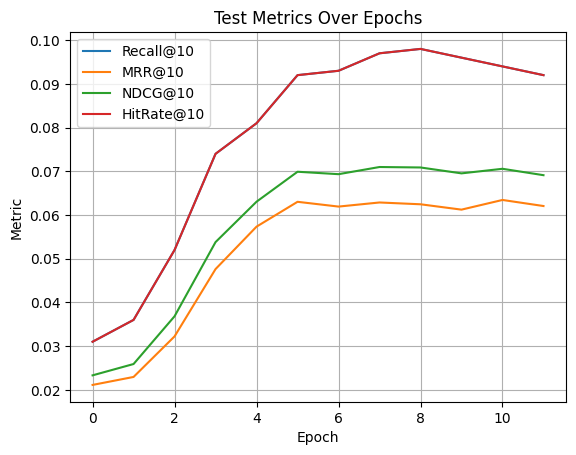

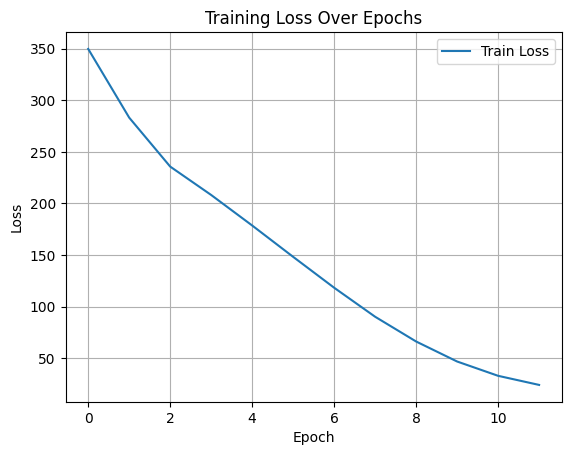


Total run time: 1.27 minutes

--------------------
Output Section 7: Sample Predictions

User ID: 479
Input sequence:
  - Item 10653: B00005UQT6
  - Item 11895: B00005US8L
  - Item 1752: B0000E6NK9
  - Item 18445: B0000AI0N8
  - Item 3042: B0002NT83U
  - Item 4235: B00062AKK2
  - Item 4877: B00062AL06
  - Item 10920: B0001G6Q2E
  - Item 2139: B0007GCXZ2
  - Item 8792: B0008GM6JO
  - Item 11337: B000HPX5O6
  - Item 1108: B000BR0NPO
  - Item 480: B000FK88JK
True next item: Item 149: B004M39SN6 (logit: 2.6031, confidence: 0.0022)
Top-10 Predictions with scores:
  1. Item 2462: B000WR2F3G (logit: 7.1199, confidence: 0.2052)
  2. Item 2135: B0013YHNEI (logit: 6.0890, confidence: 0.0732)
  3. Item 906: B000XHE0Q0 (logit: 5.0853, confidence: 0.0268)
  4. Item 2199: B002JB1TTO (logit: 5.0726, confidence: 0.0265)
  5. Item 466: B001F5VBRU (logit: 4.8904, confidence: 0.0221)
  6. Item 84: B000WR2F2M (logit: 4.8290, confidence: 0.0208)
  7. Item 7974: B000087Z1G (logit: 4.3636, confidence: 0.013

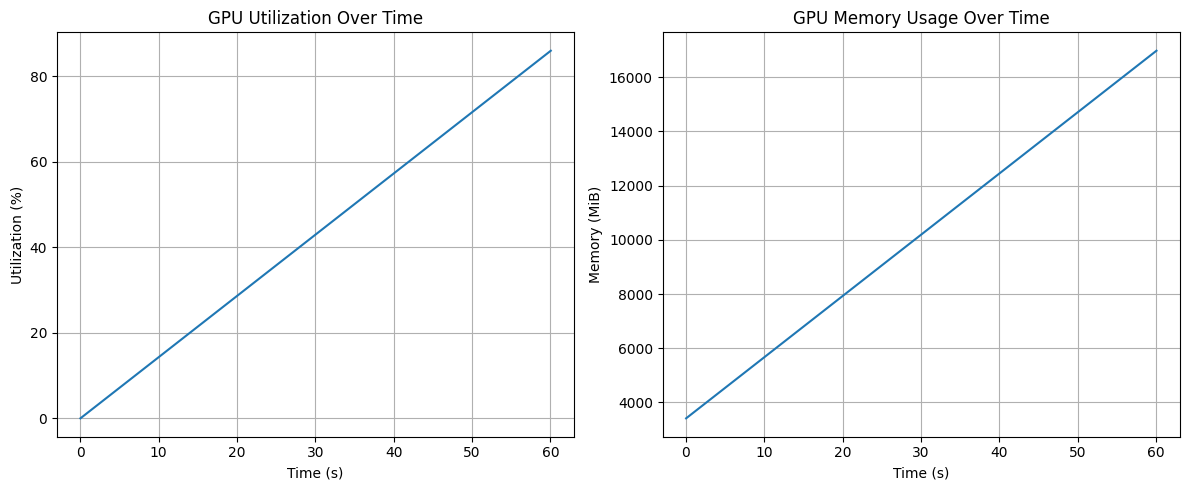


 Loading best model from: best_model_AmazonE5_xLSTM_SL:128_Emb:128_seed_2023.pt AmazonE5xLSTM
Completed

[RUN] Model: BERT4Rec | Max_len: 128 | Seed: 2023
Output Section 1: Initialization
[INFO] Model initialized. Triton should log kernel compilation now.
Allocated: 0.02 GB
Reserved : 2.86 GB
[GPU MONITOR] 0% GPU, 3251 MiB
-------------------------
Output Section 2: Important Parameters and Model Selection
Model: BERT4Rec
Dataset: AmazonE5
Epoch: 20
MAX_LEN: 128, LEARNING_RATE: 0.001
Model Params (AmazonE5): {'embedding_dim': 128, 'num_heads': 4, 'num_blocks': 2}
Dataloader Params (AmazonE5): {'batch_size': 256, 'num_workers': 4}
Length of ratings: 459436
Shape: (459436, 4)
Num users: 375147, Num items: 21663
Length of the ratings: 459436
Shape of the ratings dataframe: (459436, 4)
-------------------------
                  
Output Section 3: Input Datasets For Reference
   user_id  movie_id   timestamp       title
0        0         0  1454198400  B01617VNBK
1        1         1  14

Epoch 1: 100%|██████████| 35/35 [00:01<00:00, 30.99it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.0247, Recall@10: 0.0247, MRR@10: 0.0116, NDCG@10: 0.0146
MID_40 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 1 | Loss: 322.97 | HR@10: 0.0190 (19/1000) | Recall@10: 0.0190 | MRR@10: 0.0089 | NDCG@10: 0.0112
Saved new best model (Recall@10 = 0.0190) to best_model_AmazonE5_BERT4Rec_SL:128_Emb:128_seed_2023.pt


Epoch 2: 100%|██████████| 35/35 [00:01<00:00, 32.55it/s]


[GPU MONITOR] 57% GPU, 3259 MiB
[GPU MONITOR] 57% GPU, 3259 MiB

[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.0779, Recall@10: 0.0779, MRR@10: 0.0510, NDCG@10: 0.0573
MID_40 | HR@10: 0.0056, Recall@10: 0.0056, MRR@10: 0.0011, NDCG@10: 0.0021
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 2 | Loss: 256.95 | HR@10: 0.0610 (61/1000) | Recall@10: 0.0610 | MRR@10: 0.0395 | NDCG@10: 0.0445
Saved new best model (Recall@10 = 0.0610) to best_model_AmazonE5_BERT4Rec_SL:128_Emb:128_seed_2023.pt


Epoch 3: 100%|██████████| 35/35 [00:01<00:00, 32.73it/s]

[GPU MONITOR] 70% GPU, 3259 MiB



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1169, Recall@10: 0.1169, MRR@10: 0.0725, NDCG@10: 0.0829
MID_40 | HR@10: 0.0111, Recall@10: 0.0111, MRR@10: 0.0056, NDCG@10: 0.0070
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 3 | Loss: 209.92 | HR@10: 0.0920 (92/1000) | Recall@10: 0.0920 | MRR@10: 0.0569 | NDCG@10: 0.0651
Saved new best model (Recall@10 = 0.0920) to best_model_AmazonE5_BERT4Rec_SL:128_Emb:128_seed_2023.pt


Epoch 4: 100%|██████████| 35/35 [00:01<00:00, 31.99it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1325, Recall@10: 0.1325, MRR@10: 0.0764, NDCG@10: 0.0896
MID_40 | HR@10: 0.0167, Recall@10: 0.0167, MRR@10: 0.0093, NDCG@10: 0.0110
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 4 | Loss: 166.32 | HR@10: 0.1050 (105/1000) | Recall@10: 0.1050 | MRR@10: 0.0605 | NDCG@10: 0.0710
Saved new best model (Recall@10 = 0.1050) to best_model_AmazonE5_BERT4Rec_SL:128_Emb:128_seed_2023.pt


Epoch 5:  74%|███████▍  | 26/35 [00:00<00:00, 42.06it/s]

[GPU MONITOR] 66% GPU, 3259 MiB


Epoch 5: 100%|██████████| 35/35 [00:01<00:00, 32.65it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1325, Recall@10: 0.1325, MRR@10: 0.0800, NDCG@10: 0.0926
MID_40 | HR@10: 0.0222, Recall@10: 0.0222, MRR@10: 0.0134, NDCG@10: 0.0155
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 5 | Loss: 131.54 | HR@10: 0.1060 (106/1000) | Recall@10: 0.1060 | MRR@10: 0.0640 | NDCG@10: 0.0741
Saved new best model (Recall@10 = 0.1060) to best_model_AmazonE5_BERT4Rec_SL:128_Emb:128_seed_2023.pt


Epoch 6: 100%|██████████| 35/35 [00:01<00:00, 32.10it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1351, Recall@10: 0.1351, MRR@10: 0.0840, NDCG@10: 0.0964
MID_40 | HR@10: 0.0222, Recall@10: 0.0222, MRR@10: 0.0108, NDCG@10: 0.0136
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 6 | Loss: 105.45 | HR@10: 0.1080 (108/1000) | Recall@10: 0.1080 | MRR@10: 0.0666 | NDCG@10: 0.0767
Saved new best model (Recall@10 = 0.1080) to best_model_AmazonE5_BERT4Rec_SL:128_Emb:128_seed_2023.pt


Epoch 7: 100%|██████████| 35/35 [00:01<00:00, 32.49it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1442, Recall@10: 0.1442, MRR@10: 0.0833, NDCG@10: 0.0977
MID_40 | HR@10: 0.0222, Recall@10: 0.0222, MRR@10: 0.0144, NDCG@10: 0.0163
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 7 | Loss: 86.84 | HR@10: 0.1150 (115/1000) | Recall@10: 0.1150 | MRR@10: 0.0667 | NDCG@10: 0.0782
Saved new best model (Recall@10 = 0.1150) to best_model_AmazonE5_BERT4Rec_SL:128_Emb:128_seed_2023.pt


Epoch 8: 100%|██████████| 35/35 [00:01<00:00, 32.01it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1364, Recall@10: 0.1364, MRR@10: 0.0815, NDCG@10: 0.0946
MID_40 | HR@10: 0.0222, Recall@10: 0.0222, MRR@10: 0.0148, NDCG@10: 0.0167
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 8 | Loss: 72.89 | HR@10: 0.1090 (109/1000) | Recall@10: 0.1090 | MRR@10: 0.0654 | NDCG@10: 0.0758
 Alert for Early Stopping: No improvement for 1 epoch(s)


Epoch 9: 100%|██████████| 35/35 [00:01<00:00, 32.78it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1429, Recall@10: 0.1429, MRR@10: 0.0787, NDCG@10: 0.0936
MID_40 | HR@10: 0.0222, Recall@10: 0.0222, MRR@10: 0.0136, NDCG@10: 0.0157
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 9 | Loss: 61.47 | HR@10: 0.1140 (114/1000) | Recall@10: 0.1140 | MRR@10: 0.0630 | NDCG@10: 0.0749
 Alert for Early Stopping: No improvement for 2 epoch(s)


Epoch 10: 100%|██████████| 35/35 [00:01<00:00, 31.81it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.1338, Recall@10: 0.1338, MRR@10: 0.0807, NDCG@10: 0.0934
MID_40 | HR@10: 0.0222, Recall@10: 0.0222, MRR@10: 0.0113, NDCG@10: 0.0140
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 10 | Loss: 51.71 | HR@10: 0.1070 (107/1000) | Recall@10: 0.1070 | MRR@10: 0.0642 | NDCG@10: 0.0744
 Alert for Early Stopping: No improvement for 3 epoch(s)

 Early stopping triggered. For 3 consecutive epochs. Best Model has been saved successfully

 Loading best model from: best_model_AmazonE5_BERT4Rec_SL:128_Emb:128_seed_2023.pt

--------------------
Output Section 6: Performance Metrics


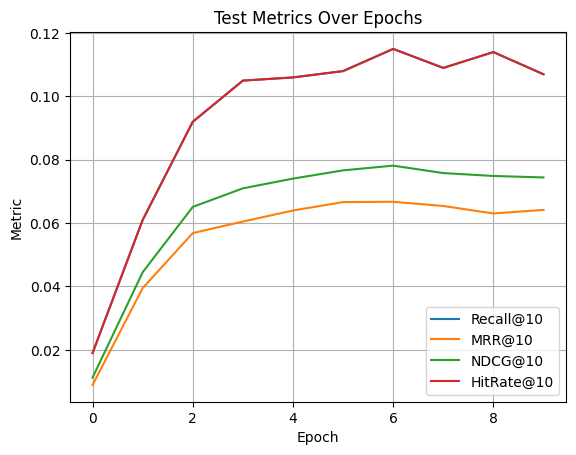

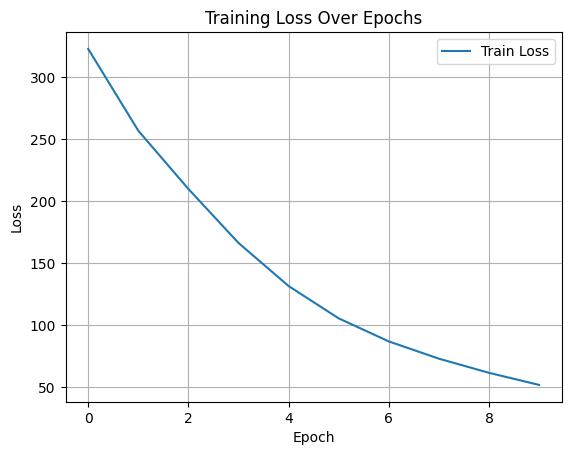


Total run time: 0.62 minutes

--------------------
Output Section 7: Sample Predictions

User ID: 479
Input sequence:
  - Item 1826: B00004TYCR
  - Item 1472: 1600775411
  - Item 980: B009YYZJDQ
  - Item 3886: B007UXEF6U
  - Item 1749: B00EZJRS8E
  - Item 29: B0144NYGJY
  - Item 244: B0148BYIAO
True next item: Item 243: B010P91LYY (logit: 7.0655, confidence: 0.1483)
Top-10 Predictions with scores:
  1. Item 244: B0148BYIAO (logit: 7.1182, confidence: 0.1563)
  2. Item 243: B010P91LYY (logit: 7.0655, confidence: 0.1483)
  3. Item 251: B00L13X6QA (logit: 6.8684, confidence: 0.1218)
  4. Item 239: B00ZSI7Y3U (logit: 6.2513, confidence: 0.0657)
  5. Item 6050: B015XDQD4K (logit: 5.5370, confidence: 0.0322)
  6. Item 1218: B004Q0T0LU (logit: 4.9213, confidence: 0.0174)
  7. Item 526: B01637RFR4 (logit: 4.3639, confidence: 0.0100)
  8. Item 574: 0763855553 (logit: 4.1741, confidence: 0.0082)
  9. Item 80: B00F8K9L66 (logit: 3.5703, confidence: 0.0045)
  10. Item 555: B01326J6GW (logit: 3.56

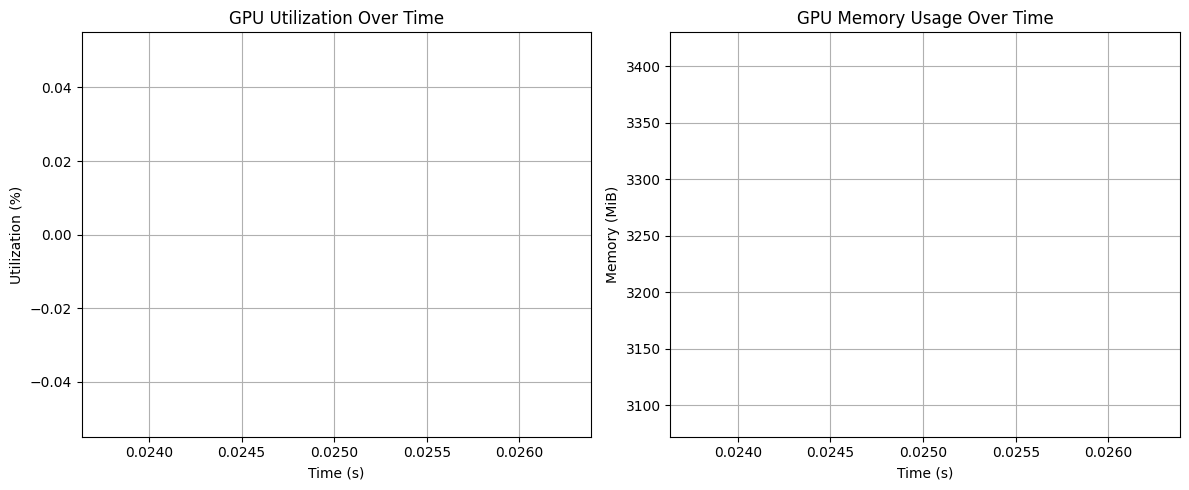


 Loading best model from: best_model_AmazonE5_BERT4Rec_SL:128_Emb:128_seed_2023.pt AmazonE5BERT4Rec
Completed

[RUN] Model: SAS4Rec | Max_len: 128 | Seed: 2023
Output Section 1: Initialization
[INFO] Model initialized. Triton should log kernel compilation now.
Allocated: 0.02 GB
Reserved : 2.86 GB
[GPU MONITOR] 0% GPU, 3251 MiB
[GPU MONITOR] 0% GPU, 3251 MiB
-------------------------
Output Section 2: Important Parameters and Model Selection
Model: SAS4Rec
Dataset: AmazonE5
Epoch: 20
MAX_LEN: 128, LEARNING_RATE: 0.001
Model Params (AmazonE5): {'embedding_dim': 128, 'num_heads': 4, 'num_blocks': 2}
Dataloader Params (AmazonE5): {'batch_size': 256, 'num_workers': 4}
Length of ratings: 459436
Shape: (459436, 4)
Num users: 375147, Num items: 21663
Length of the ratings: 459436
Shape of the ratings dataframe: (459436, 4)
-------------------------
                  
Output Section 3: Input Datasets For Reference
   user_id  movie_id   timestamp       title
0        0         0  1454198400  

Epoch 1: 100%|██████████| 35/35 [00:01<00:00, 32.35it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.0065, Recall@10: 0.0065, MRR@10: 0.0012, NDCG@10: 0.0024
MID_40 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 1 | Loss: 321.85 | HR@10: 0.0050 (5/1000) | Recall@10: 0.0050 | MRR@10: 0.0009 | NDCG@10: 0.0019
Saved new best model (Recall@10 = 0.0050) to best_model_AmazonE5_SAS4Rec_SL:128_Emb:128_seed_2023.pt


Epoch 2: 100%|██████████| 35/35 [00:01<00:00, 32.51it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.0065, Recall@10: 0.0065, MRR@10: 0.0012, NDCG@10: 0.0024
MID_40 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 2 | Loss: 256.43 | HR@10: 0.0050 (5/1000) | Recall@10: 0.0050 | MRR@10: 0.0009 | NDCG@10: 0.0019
 Alert for Early Stopping: No improvement for 1 epoch(s)


Epoch 3: 100%|██████████| 35/35 [00:01<00:00, 32.90it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.0065, Recall@10: 0.0065, MRR@10: 0.0012, NDCG@10: 0.0024
MID_40 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 3 | Loss: 207.39 | HR@10: 0.0050 (5/1000) | Recall@10: 0.0050 | MRR@10: 0.0009 | NDCG@10: 0.0019
 Alert for Early Stopping: No improvement for 2 epoch(s)


Epoch 4: 100%|██████████| 35/35 [00:01<00:00, 33.86it/s]



[Popularity-Bucketed Performance Metrics]
TOP_10 | HR@10: 0.0065, Recall@10: 0.0065, MRR@10: 0.0012, NDCG@10: 0.0024
MID_40 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
BOTTOM_50 | HR@10: 0.0000, Recall@10: 0.0000, MRR@10: 0.0000, NDCG@10: 0.0000
Epoch 4 | Loss: 161.76 | HR@10: 0.0050 (5/1000) | Recall@10: 0.0050 | MRR@10: 0.0009 | NDCG@10: 0.0019
 Alert for Early Stopping: No improvement for 3 epoch(s)

 Early stopping triggered. For 3 consecutive epochs. Best Model has been saved successfully

 Loading best model from: best_model_AmazonE5_SAS4Rec_SL:128_Emb:128_seed_2023.pt

--------------------
Output Section 6: Performance Metrics


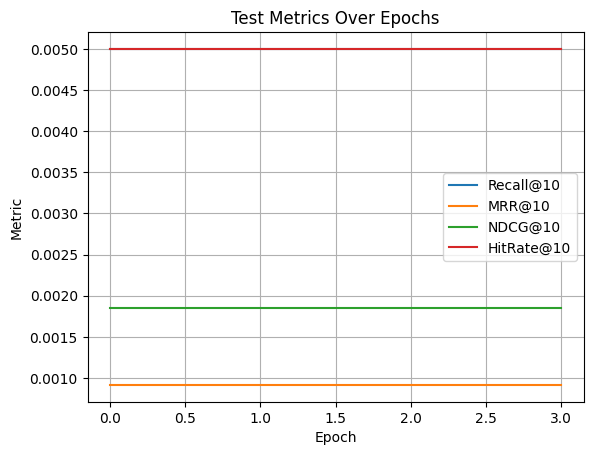

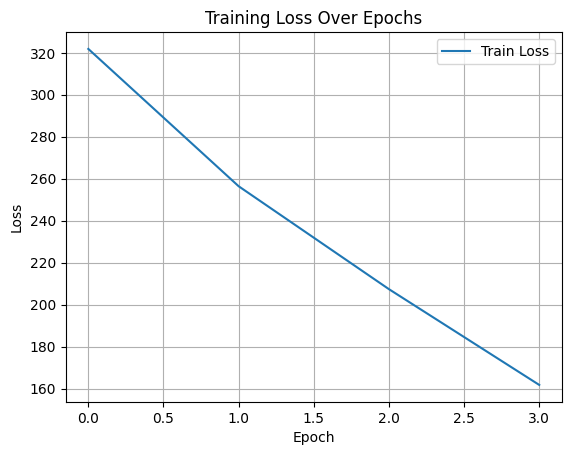


Total run time: 0.47 minutes

--------------------
Output Section 7: Sample Predictions

User ID: 479
Input sequence:
  - Item 1352: B000Y7Y6IQ
  - Item 429: B0013O54OE
  - Item 1352: B000Y7Y6IQ
  - Item 429: B0013O54OE
  - Item 1258: B001AFD20E
  - Item 552: B001EJTO8A
  - Item 1073: B001EHXOFG
  - Item 2199: B002JB1TTO
  - Item 289: B01F7RJHIQ
  - Item 413: B00ENFVSIQ
True next item: Item 823: B01488541O (logit: nan, confidence: nan)
Top-10 Predictions with scores:
  1. Item 7: B00H09BO2M (logit: nan, confidence: nan)
  2. Item 6: B016CEG2JU (logit: nan, confidence: nan)
  3. Item 4: B007A7JSMM (logit: nan, confidence: nan)
  4. Item 5: B00H9A60O4 (logit: nan, confidence: nan)
  5. Item 1: B00MCLGAZ4 (logit: nan, confidence: nan)
  6. Item 0: B01617VNBK (logit: nan, confidence: nan)
  7. Item 2: B00SX73LIK (logit: nan, confidence: nan)
  8. Item 3: B019QVZDSC (logit: nan, confidence: nan)
  9. Item 8: B00U1UELFE (logit: nan, confidence: nan)
  10. Item 9: B00D9ILKGS (logit: nan, con

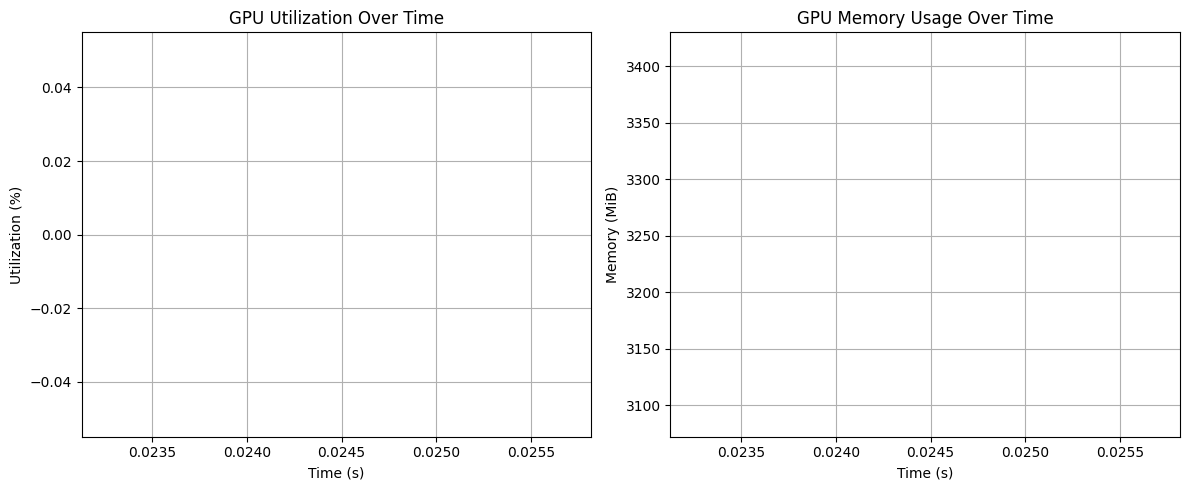


 Loading best model from: best_model_AmazonE5_SAS4Rec_SL:128_Emb:128_seed_2023.pt AmazonE5SAS4Rec
Completed


In [33]:
# Configuration
MOVIELENS_VERSION = movielens_version = "AmazonE5"
EPOCHS = epochs = 20

MAX_LEN = max_lens = [128]  # For the first time for testing
#MAX_LEN = max_lens = [32, 64, 128]  # Later to try all three seeds

seeds = [2023] # For the first time for testing
#seeds = [42, 123, 2023] # Later to loop all three seeds continously

patience = 3
#model_selections = ["xLSTM"]
model_selections = ["xLSTM", "BERT4Rec", "SAS4Rec"]

# Set seed
def set_seed(seed):
    import random, numpy as np, torch
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Main wrapper with model, max_len, seed loops
def model_main():
    global MODEL_SELECTION, MAX_LEN, seed  # keep global visibility for your internal usage

    for model_name in model_selections:
        MODEL_SELECTION = model_name

        for max_len_val in max_lens:
            MAX_LEN = max_len_val  # update global MAX_LEN for this run

            for seed_val in seeds:
                seed = seed_val  # update global seed for this run
                print(f"\n[RUN] Model: {model_name} | Max_len: {MAX_LEN} | Seed: {seed}")
                run_with_seed_and_model(model_name, seed, MAX_LEN)

# Pass everything to main logic
def run_with_seed_and_model(model_name, seed, max_len):
    set_seed(seed)
    recommender_main(model_name, seed, max_len)

# # Example of recommender_main adjusted for explicit args
# def recommender_main(model_name, seed, max_len):
#     log_dir = f"runs/{model_name}_{MOVIELENS_VERSION}_SL:{max_len}_seed_{seed}"
#     save_path = f"best_model_{MOVIELENS_VERSION}_{model_name}_SL:{max_len}_seed_{seed}.pt"

#     print(f"[INFO] Logging to {log_dir}")
#     print(f"[INFO] Saving best model to {save_path}")

#     # Rest of your training logic continues here...

# Entry point
if __name__ == "__main__":
    model_main()

In [28]:
# # Configuration
# MOVIELENS_VERSION = movielens_version = "100K"
# EPOCHS = epochs = 2
# MAX_LEN = max_len = 100
# seeds = [42, 123, 2023]
# patience = 3
# model_selections = ["LSTM","BERT4Rec", "SAS4Rec"]  # Or ["LSTM", "xLSTM", "BERT4Rec", "SAS4Rec"]

# # Set seed
# def set_seed(seed):
#     import random, numpy as np, torch
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# # Main wrapper
# def model_main():
#     for model_name in model_selections:
#         global MODEL_SELECTION, seed
#         MODEL_SELECTION = model_name
#         for seed in seeds:
#             print(f"\n[RUN] Model: {model_name} | Seed: {seed}")
#             run_with_seed_and_model(model_name, seed)

# # Call the main training logic with controlled config
# def run_with_seed_and_model(model_name, seed):
#     set_seed(seed)
#     recommender_main(model_name, seed)

# if __name__ == "__main__":
#     model_main()


In [29]:
import os
import shutil
from datetime import datetime
from google.colab import drive

drive.mount('/content/drive')

timestamp = datetime.now().strftime("%d%m%y:%H%M%S")

# Convert seeds and model selections to compact strings
seed_str = '-'.join(map(str, seeds))
model_str = '-'.join(model_selections)

# Folder name: timestamp + version + epochs + max_len + seeds + models
folder_name = f"{timestamp}_v{movielens_version}_ep{epochs}_maxlen{MAX_LEN}_seeds[{seed_str}]_models[{model_str}]"

base_drive_dir = '/content/drive/MyDrive/model_outputs'
target_dir = os.path.join(base_drive_dir, folder_name)
os.makedirs(target_dir, exist_ok=True)
print(f"Created folder: {target_dir}")

items = [f for f in os.listdir('.') if not f.startswith('.') and f not in ['sample_data', 'drive']]

for item in items:
    src_path = os.path.join('.', item)
    dest_path = os.path.join(target_dir, item)
    try:
        if os.path.isdir(src_path):
            shutil.copytree(src_path, dest_path)
            print(f"Copied folder: {item}")
        else:
            shutil.copy2(src_path, dest_path)
            print(f"Copied file: {item}")
    except Exception as e:
        print(f"Failed to copy {item}: {e}")

print(" All data copied to:", target_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created folder: /content/drive/MyDrive/model_outputs/250925:230812_vAmazonE5_ep1_maxlen128_seeds[2023]_models[xLSTM-BERT4Rec-SAS4Rec]
[GPU MONITOR] 0% GPU, 3425 MiB
Copied folder: runs
Copied file: Electronics.json.gz
Copied file: best_model_AmazonE5_xLSTM_SL:128_Emb:128_seed_2023.pt
Copied file: best_model_AmazonE5_SAS4Rec_SL:128_Emb:128_seed_2023.pt
Copied file: Software.json
Copied file: best_model_AmazonE5_BERT4Rec_SL:128_Emb:128_seed_2023.pt
 All data copied to: /content/drive/MyDrive/model_outputs/250925:230812_vAmazonE5_ep1_maxlen128_seeds[2023]_models[xLSTM-BERT4Rec-SAS4Rec]


In [ ]:
import os
import time
import pandas as pd
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
from tabulate import tabulate

script_start_time = time.time()

runs_dir = './runs'
ref_model_name = "BERT4Rec"

all_scalars = []

# Load all scalar values from TensorBoard event files
for root, dirs, files in os.walk(runs_dir):
    for file in files:
        if file.startswith('events.out.tfevents'):
            file_path = os.path.join(root, file)
            print(f"Processing: {file_path}")

            ea = event_accumulator.EventAccumulator(file_path, size_guidance={'scalars': 0})
            ea.Reload()

            tags = ea.Tags().get('scalars', [])

            folder_name = os.path.basename(root)
            parts = folder_name.split('_')

            model_name = parts[0] if len(parts) > 0 else 'Unknown'
            dataset = parts[1] if len(parts) > 1 else 'Unknown'

            seq_len = 'Unknown'
            seed = 'Unknown'

            for idx, part in enumerate(parts):
                if part == 'SL' and idx + 1 < len(parts):
                    seq_len = parts[idx + 1]
                if part == 'seed' and idx + 1 < len(parts):
                    seed = parts[idx + 1]

            for tag in tags:
                values = [e.value for e in ea.Scalars(tag)]
                for val in values:
                    all_scalars.append({
                        'Model': model_name,
                        'Dataset': dataset,
                        'Seq Len': seq_len,
                        'Seed': seed,
                        'Metric': tag,
                        'Value': val
                    })

# Convert to DataFrame
df = pd.DataFrame(all_scalars)

if df.empty:
    print("No valid TensorBoard run files found.")
else:
    agg_df = df.groupby(["Model", "Dataset", "Seq Len", "Metric"]).agg({
        "Value": ["mean", "std"]
    }).reset_index()
    agg_df.columns = ["Model", "Dataset", "Seq Len", "Metric", "Mean", "Std"]

    pivot_df = agg_df.pivot_table(index=["Model", "Dataset", "Seq Len"], columns="Metric", values=["Mean", "Std"])
    pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
    pivot_df = pivot_df.reset_index()

    pivot_df["Seq Len"] = pd.to_numeric(pivot_df["Seq Len"], errors='coerce')

    # Format aggregate metrics
    pivot_df["Recall@10"] = pivot_df.apply(
        lambda x: f"{x['Mean_Recall@10/test']:.4f} ± {x['Std_Recall@10/test']:.4f}" if "Mean_Recall@10/test" in x else "N/A",
        axis=1
    )
    pivot_df["NDCG@10"] = pivot_df.apply(
        lambda x: f"{x['Mean_NDCG@10/test']:.4f} ± {x['Std_NDCG@10/test']:.4f}" if "Mean_NDCG@10/test" in x else "N/A",
        axis=1
    )
    pivot_df["MRR@10"] = pivot_df.apply(
        lambda x: f"{x['Mean_MRR@10/test']:.4f} ± {x['Std_MRR@10/test']:.4f}" if "Mean_MRR@10/test" in x else "N/A",
        axis=1
    )

    if "Mean_Model/TotalParams" in pivot_df.columns:
        pivot_df["TotalParams"] = pivot_df["Mean_Model/TotalParams"].apply(lambda x: f"{x:,.0f}")
    else:
        pivot_df["TotalParams"] = "N/A"

    # Estimate total time (minutes)
    if "Mean_EpochTime" in pivot_df.columns:
        pivot_df["TotalTime(mins)"] = pivot_df["Mean_EpochTime"] * df.groupby(["Model", "Dataset", "Seq Len"])["Metric"].apply(lambda x: df[df["Metric"] == "EpochTime"].groupby(["Model", "Dataset", "Seq Len"]).size().get((x.name[0], x.name[1], x.name[2]), np.nan)).values / 60
        pivot_df["TotalTime(mins)"] = pivot_df["TotalTime(mins)"].apply(lambda x: f"{x:.2f}" if not pd.isna(x) else "N/A")
    else:
        pivot_df["TotalTime(mins)"] = "N/A"

    # Build long-form bucketed metrics table
    bucket_names = ["top_10", "mid_40", "bottom_50"]
    bucket_metric_rows = []

    for _, row in pivot_df.iterrows():
        for bucket in bucket_names:
            bucket_row = {
                "Model": row["Model"],
                "Dataset": row["Dataset"],
                "Seq Len": row["Seq Len"],
                "Bucket": bucket,
                "Recall@10": f"{row.get(f'Mean_Recall@10/test_{bucket}', np.nan):.4f} ± {row.get(f'Std_Recall@10/test_{bucket}', np.nan):.4f}"
                if not pd.isna(row.get(f'Mean_Recall@10/test_{bucket}', np.nan)) else "N/A",
                "MRR@10": f"{row.get(f'Mean_MRR@10/test_{bucket}', np.nan):.4f} ± {row.get(f'Std_MRR@10/test_{bucket}', np.nan):.4f}"
                if not pd.isna(row.get(f'Mean_MRR@10/test_{bucket}', np.nan)) else "N/A",
                "NDCG@10": f"{row.get(f'Mean_NDCG@10/test_{bucket}', np.nan):.4f} ± {row.get(f'Std_NDCG@10/test_{bucket}', np.nan):.4f}"
                if not pd.isna(row.get(f'Mean_NDCG@10/test_{bucket}', np.nan)) else "N/A"
            }
            bucket_metric_rows.append(bucket_row)

    bucket_df = pd.DataFrame(bucket_metric_rows)

    # Final wide-form summary table
    final_cols = ["Model", "Dataset", "Seq Len", "TotalParams", "Recall@10", "NDCG@10", "MRR@10", "TotalTime(mins)"]
    if "Mean_HitRate@10/test" in pivot_df.columns:
        final_cols.append("Mean_HitRate@10/test")
    if "Mean_Loss/train" in pivot_df.columns:
        final_cols.append("Mean_Loss/train")
    if "Mean_EpochTime" in pivot_df.columns:
        final_cols.append("Mean_EpochTime")

    final_df = pivot_df[final_cols].sort_values(by=["Model", "Dataset", "Seq Len"]).reset_index(drop=True)

    # Print results
    print("\nConsolidated Results (All Scalars Aggregated):\n")
    print(tabulate(final_df, headers="keys", tablefmt="github", showindex=False))

    print("\nPopularity-Bucketed Metrics (Per Model):\n")
    print(tabulate(bucket_df, headers="keys", tablefmt="github", showindex=False))

    # Save results
    final_df.to_excel("tensorboard_summary_aggregated.xlsx", index=False)
    bucket_df.to_excel("tensorboard_bucketed_metrics.xlsx", index=False)

    print("\nSaved: 'tensorboard_summary_aggregated.xlsx'")
    print("Saved: 'tensorboard_bucketed_metrics.xlsx'")

# Total script time
elapsed_minutes = (time.time() - script_start_time) / 60
print(f"\n[INFO] Total script run time: {elapsed_minutes:.2f} minutes")


In [ ]:
# This triggers the save function in the Colab frontend
import IPython
IPython.display.display(IPython.display.Javascript('IPython.notebook.save_checkpoint();'))


In [ ]:

import os
import pandas as pd
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
from tabulate import tabulate

runs_dir = './runs'
ref_model_name = "BERT4Rec"

all_scalars = []

for root, dirs, files in os.walk(runs_dir):
    for file in files:
        if file.startswith('events.out.tfevents'):
            file_path = os.path.join(root, file)
            print(f"Processing: {file_path}")

            ea = event_accumulator.EventAccumulator(file_path, size_guidance={'scalars': 0})
            ea.Reload()

            tags = ea.Tags().get('scalars', [])

            folder_name = os.path.basename(root)
            model_name = folder_name.split('_')[0] if '_' in folder_name else 'Unknown'

            seq_len, seed = 'Unknown', 'Unknown'
            for part in folder_name.split('_'):
                if 'SL:' in part:
                    seq_len = part.split(':')[-1]
                if 'seed' in part:
                    seed = part.split(':')[-1]

            for tag in tags:
                values = [e.value for e in ea.Scalars(tag)]

                for val in values:
                    all_scalars.append({
                        'Model': model_name,
                        'Seq Len': seq_len,
                        'Seed': seed,
                        'Metric': tag,
                        'Value': val
                    })

# Convert to DataFrame
df = pd.DataFrame(all_scalars)

if df.empty:
    print("No valid TensorBoard run files found.")
else:
    df.to_excel("tensorboard_all_scalars.xlsx", index=False)
    print("Saved all scalar values to 'tensorboard_all_scalars.xlsx'")

    agg_df = df.groupby(["Model", "Seq Len", "Metric"]).agg({
        "Value": ["mean", "std"]
    }).reset_index()

    agg_df.columns = ["Model", "Seq Len", "Metric", "Mean", "Std"]

    pivot_df = agg_df.pivot_table(index=["Model", "Seq Len"], columns="Metric", values=["Mean", "Std"])
    pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
    pivot_df = pivot_df.reset_index()

    # Extract baselines for delta
    ref_row = pivot_df[pivot_df["Model"] == ref_model_name]
    ref_recall = ref_row["Mean_Recall@10/test"].values[0] if "Mean_Recall@10/test" in ref_row else None
    ref_ndcg = ref_row["Mean_NDCG@10/test"].values[0] if "Mean_NDCG@10/test" in ref_row else None
    ref_mrr = ref_row["Mean_MRR@10/test"].values[0] if "Mean_MRR@10/test" in ref_row else None

    # Format Recall
    if ref_recall is not None:
        pivot_df["Recall@10"] = pivot_df.apply(
            lambda x: f"{x['Mean_Recall@10/test']:.4f} ({((x['Mean_Recall@10/test'] - ref_recall) / ref_recall) * 100:+.2f}%) ± {x['Std_Recall@10/test']:.4f}"
            if "Mean_Recall@10/test" in x else "N/A",
            axis=1
        )
    else:
        pivot_df["Recall@10"] = pivot_df.apply(
            lambda x: f"{x['Mean_Recall@10/test']:.4f} ± {x['Std_Recall@10/test']:.4f}" if "Mean_Recall@10/test" in x else "N/A",
            axis=1
        )

    # Format NDCG
    if ref_ndcg is not None:
        pivot_df["NDCG@10"] = pivot_df.apply(
            lambda x: f"{x['Mean_NDCG@10/test']:.4f} ({((x['Mean_NDCG@10/test'] - ref_ndcg) / ref_ndcg) * 100:+.2f}%) ± {x['Std_NDCG@10/test']:.4f}"
            if "Mean_NDCG@10/test" in x else "N/A",
            axis=1
        )
    else:
        pivot_df["NDCG@10"] = pivot_df.apply(
            lambda x: f"{x['Mean_NDCG@10/test']:.4f} ± {x['Std_NDCG@10/test']:.4f}" if "Mean_NDCG@10/test" in x else "N/A",
            axis=1
        )

    # Format MRR
    if ref_mrr is not None:
        pivot_df["MRR@10"] = pivot_df.apply(
            lambda x: f"{x['Mean_MRR@10/test']:.4f} ({((x['Mean_MRR@10/test'] - ref_mrr) / ref_mrr) * 100:+.2f}%) ± {x['Std_MRR@10/test']:.4f}"
            if "Mean_MRR@10/test" in x else "N/A",
            axis=1
        )
    else:
        pivot_df["MRR@10"] = pivot_df.apply(
            lambda x: f"{x['Mean_MRR@10/test']:.4f} ± {x['Std_MRR@10/test']:.4f}" if "Mean_MRR@10/test" in x else "N/A",
            axis=1
        )

    # Include TotalParams if available
    if "Mean_Model/TotalParams" in pivot_df.columns:
        pivot_df["TotalParams"] = pivot_df["Mean_Model/TotalParams"].apply(lambda x: f"{x:,.0f}")
    else:
        pivot_df["TotalParams"] = "N/A"

    # Define final columns
    final_cols = ["Model", "Seq Len", "TotalParams", "Recall@10", "NDCG@10", "MRR@10"]

    # Optionally add other raw metrics
    if "Mean_HitRate@10/test" in pivot_df.columns:
        final_cols.append("Mean_HitRate@10/test")
    if "Mean_Loss/train" in pivot_df.columns:
        final_cols.append("Mean_Loss/train")
    if "Mean_EpochTime" in pivot_df.columns:
        final_cols.append("Mean_EpochTime")

    final_df = pivot_df[final_cols]

    print("\nConsolidated Results (All Scalars Aggregated):\n")
    print(tabulate(final_df.sort_values(by=["Model", "Seq Len"]), headers="keys", tablefmt="github", showindex=False))

    final_df.to_excel("tensorboard_summary_aggregated.xlsx", index=False)
    print("Saved final summary table to 'tensorboard_summary_aggregated.xlsx'")

In [ ]:
# import time
# time.sleep(60)

In [ ]:
# MOVIELENS_VERSION = "100K"  # Choose from "100K","1M","10M","20M"
# MODEL_SELECTION = "BERT4Rec"  # "LSTM", "xLSTM", "BERT4Rec", "SAS4Rec"
# EPOCHS = 20
# MAX_LEN = 75

# recommender_main()

# #early stopping
# patience = 3
# # Run the Main Script after selection

Main Script

In [ ]:
# time.sleep(60)

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs/

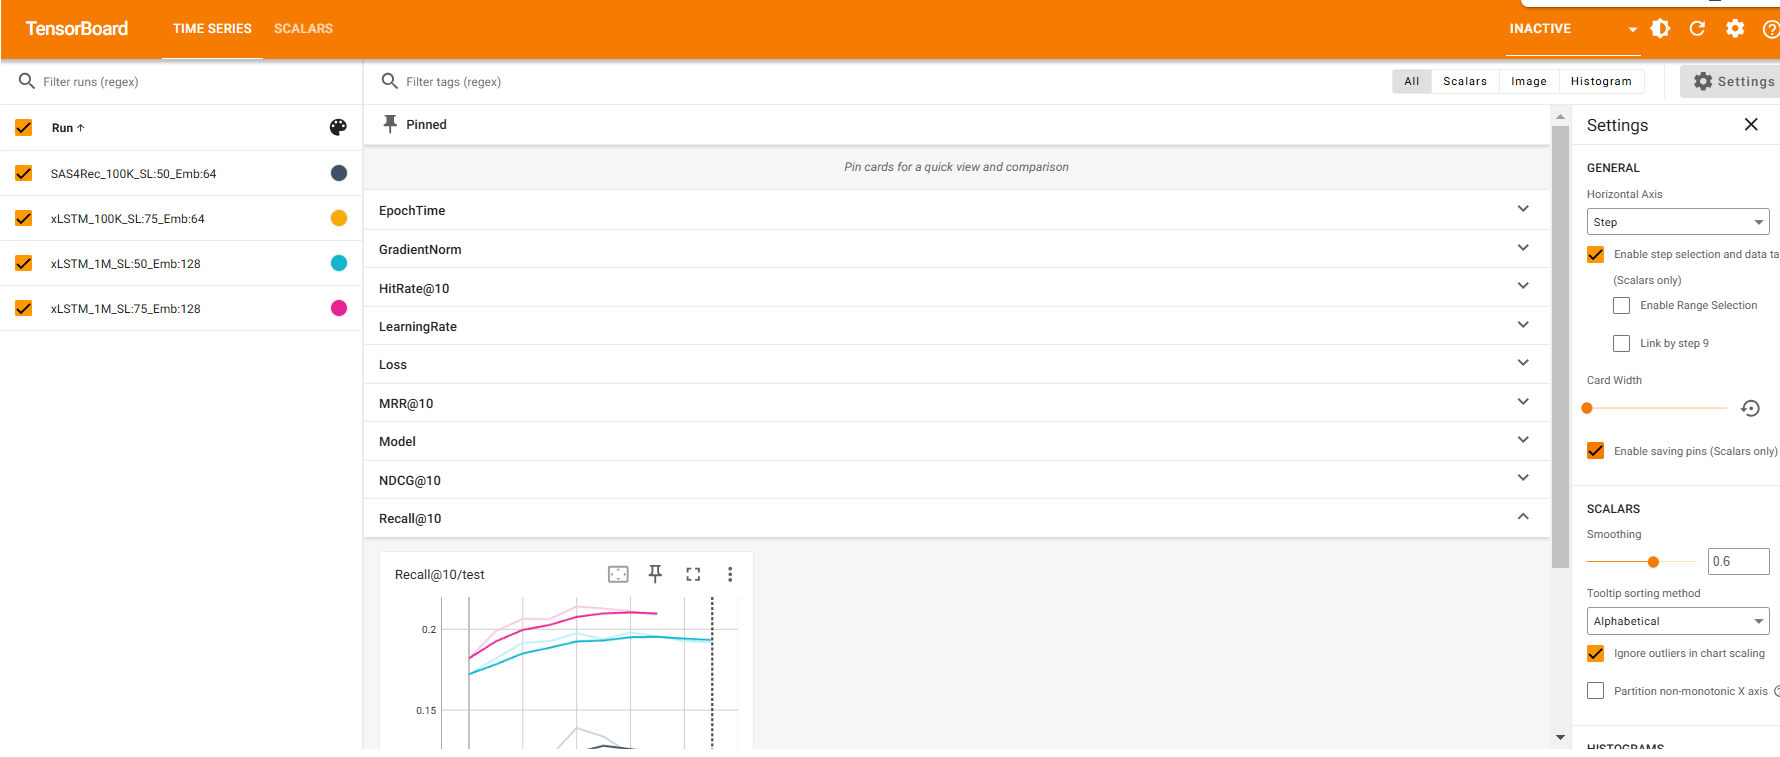

In [ ]:
!pip install -q torchinfo torchview

In [ ]:
print_model_summary(model, input_size=(1, MAX_LEN))
save_model_diagram(model, input_size=(1, MAX_LEN), filename=MODEL_SELECTION)

In [ ]:
import torch
import torch.nn as nn
from torchinfo import summary
from torchview import draw_graph
import os
from transformers import BertModel, BertConfig

# Dummy xLSTM Config/Model for Visualization Example
class xLSTMLargeConfig:
    def __init__(self, embedding_dim, num_heads, num_blocks, vocab_size, return_last_states, mode, chunkwise_kernel, sequence_kernel, step_kernel):
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.num_blocks = num_blocks
        self.vocab_size = vocab_size
        self.return_last_states = return_last_states
        self.mode = mode

class xLSTMLarge(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.lstm = nn.LSTM(config.embedding_dim, config.embedding_dim, batch_first=True)
        self.output_layer = nn.Linear(config.embedding_dim, config.vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        return self.output_layer(out[:, -1, :])

# ---------------- Model Definitions ----------------

class LSTMModel(nn.Module):
    def __init__(self, num_items, embedding_dim, hidden_dim, num_layers, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(num_items + 1, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_dim, num_items + 1)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.output_layer(out)

class BERT4RecModel(nn.Module):
    def __init__(self, num_items, params, max_len):
        super().__init__()
        config = BertConfig(
            vocab_size=num_items + 1,
            hidden_size=params["embedding_dim"],
            num_hidden_layers=params["num_blocks"],
            num_attention_heads=params["num_heads"],
            intermediate_size=params["embedding_dim"] * 4,
            max_position_embeddings=max_len + 2
        )
        self.bert = BertModel(config)
        self.norm = nn.LayerNorm(config.hidden_size)
        self.output_layer = nn.Linear(config.hidden_size, num_items + 1)

    def forward(self, x):
        attention_mask = (x != 0).long()
        out = self.bert(input_ids=x, attention_mask=attention_mask).last_hidden_state
        out = self.norm(out[:, -1, :])
        return self.output_layer(out)

class SASRecModel(nn.Module):
    def __init__(self, num_items, hidden_dim, max_len, num_heads, num_blocks):
        super().__init__()
        self.item_embedding = nn.Embedding(num_items + 1, hidden_dim, padding_idx=0)
        self.pos_embedding = nn.Embedding(max_len, hidden_dim)
        self.attention_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(hidden_dim, num_heads, dim_feedforward=hidden_dim * 4, batch_first=True)
            for _ in range(num_blocks)
        ])
        self.output_layer = nn.Linear(hidden_dim, num_items + 1)

    def forward(self, x):
        positions = torch.arange(x.size(1), device=x.device).unsqueeze(0)
        x_emb = self.item_embedding(x) + self.pos_embedding(positions)
        attn_mask = torch.triu(torch.full((x.size(1), x.size(1)), float("-inf"), device=x.device), diagonal=1)
        key_padding_mask = (x == 0)
        for block in self.attention_blocks:
            x_emb = block(x_emb, src_mask=attn_mask, src_key_padding_mask=key_padding_mask)
        return self.output_layer(x_emb[:, -1, :])

# ---------------- Visualization Utility ----------------

def visualize_model(model, model_name, max_len, num_items):
    print(f"\n[INFO] Summary for {model_name}\n")
    summary(model, input_size=(1, max_len), dtypes=[torch.long])

    os.makedirs("model_diagrams", exist_ok=True)
    dummy_input = torch.randint(0, num_items, (1, max_len), dtype=torch.long)
    graph = draw_graph(model, input_data=dummy_input, expand_nested=True)
    graph.visual_graph.render(f"model_diagrams/{model_name}", view=False, format="png")
    print(f"[INFO] Diagram saved: model_diagrams/{model_name}.png")

# ---------------- Example Usage ----------------

# Common params
num_items = 1000
params = {"embedding_dim": 128, "num_heads": 4, "num_blocks": 2}
MAX_LEN = 50

# LSTM
lstm_model = LSTMModel(num_items, params["embedding_dim"], params["embedding_dim"], num_layers=1)
visualize_model(lstm_model, "LSTMModel", MAX_LEN, num_items)

# BERT4Rec
bert_model = BERT4RecModel(num_items, params, MAX_LEN)
visualize_model(bert_model, "BERT4RecModel", MAX_LEN, num_items)

# SASRec
sasrec_model = SASRecModel(num_items, params["embedding_dim"], MAX_LEN, params["num_heads"], params["num_blocks"])
visualize_model(sasrec_model, "SASRecModel", MAX_LEN, num_items)

# xLSTM (Dummy version)
xlstm_cfg = xLSTMLargeConfig(
    embedding_dim=params["embedding_dim"], num_heads=params["num_heads"], num_blocks=params["num_blocks"],
    vocab_size=num_items + 1, return_last_states=True, mode="train",
    chunkwise_kernel="chunkwise--triton_xl_chunk", sequence_kernel="native_sequence__triton", step_kernel="triton"
)
xlstm_model = xLSTMLarge(xlstm_cfg)
visualize_model(xlstm_model, "xLSTMModel", MAX_LEN, num_items)

In [ ]:
print(xlstm_model)

In [ ]:
import os
import pandas as pd
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
from tabulate import tabulate

runs_dir = './runs'  # Set to '.' to scan the entire current directory
ref_model_name = "BERT4Rec"  # Still keeps track, but no % improvement calculated

all_scalars = []

for root, dirs, files in os.walk(runs_dir):
    for file in files:
        if file.startswith('events.out.tfevents'):
            file_path = os.path.join(root, file)
            print(f"Processing: {file_path}")

            ea = event_accumulator.EventAccumulator(file_path, size_guidance={'scalars': 0})
            ea.Reload()

            tags = ea.Tags().get('scalars', [])

            folder_name = os.path.basename(root)
            parts = folder_name.split('_')

            model_name = parts[0] if len(parts) > 0 else 'Unknown'
            dataset = parts[1] if len(parts) > 1 else 'Unknown'

            seq_len = 'Unknown'
            seed = 'Unknown'

            for idx, part in enumerate(parts):
                if part == 'SL' and idx + 1 < len(parts):
                    seq_len = parts[idx + 1]
                if part == 'seed' and idx + 1 < len(parts):
                    seed = parts[idx + 1]

            for tag in tags:
                values = [e.value for e in ea.Scalars(tag)]

                for val in values:
                    all_scalars.append({
                        'Model': model_name,
                        'Dataset': dataset,
                        'Seq Len': seq_len,
                        'Seed': seed,
                        'Metric': tag,
                        'Value': val
                    })

# Convert to DataFrame
df = pd.DataFrame(all_scalars)

if df.empty:
    print("No valid TensorBoard run files found.")
else:
    # df.to_excel("tensorboard_all_scalars.xlsx", index=False)
    # print("Saved all scalar values to 'tensorboard_all_scalars.xlsx'")

    agg_df = df.groupby(["Model", "Dataset", "Seq Len", "Metric"]).agg({
        "Value": ["mean", "std"]
    }).reset_index()

    agg_df.columns = ["Model", "Dataset", "Seq Len", "Metric", "Mean", "Std"]

    pivot_df = agg_df.pivot_table(index=["Model", "Dataset", "Seq Len"], columns="Metric", values=["Mean", "Std"])
    pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
    pivot_df = pivot_df.reset_index()

    # Convert Seq Len to numeric for sorting
    pivot_df["Seq Len"] = pd.to_numeric(pivot_df["Seq Len"], errors='coerce')

    # Format Recall
    pivot_df["Recall@10"] = pivot_df.apply(
        lambda x: f"{x['Mean_Recall@10/test']:.4f} ± {x['Std_Recall@10/test']:.4f}" if "Mean_Recall@10/test" in x else "N/A",
        axis=1
    )

    # Format NDCG
    pivot_df["NDCG@10"] = pivot_df.apply(
        lambda x: f"{x['Mean_NDCG@10/test']:.4f} ± {x['Std_NDCG@10/test']:.4f}" if "Mean_NDCG@10/test" in x else "N/A",
        axis=1
    )

    # Format MRR
    pivot_df["MRR@10"] = pivot_df.apply(
        lambda x: f"{x['Mean_MRR@10/test']:.4f} ± {x['Std_MRR@10/test']:.4f}" if "Mean_MRR@10/test" in x else "N/A",
        axis=1
    )

    # Include TotalParams if available
    if "Mean_Model/TotalParams" in pivot_df.columns:
        pivot_df["TotalParams"] = pivot_df["Mean_Model/TotalParams"].apply(lambda x: f"{x:,.0f}")
    else:
        pivot_df["TotalParams"] = "N/A"

    # Final columns
    final_cols = ["Model", "Dataset", "Seq Len", "TotalParams", "Recall@10", "NDCG@10", "MRR@10"]

    # Optional extras
    if "Mean_HitRate@10/test" in pivot_df.columns:
        final_cols.append("Mean_HitRate@10/test")
    if "Mean_Loss/train" in pivot_df.columns:
        final_cols.append("Mean_Loss/train")
    if "Mean_EpochTime" in pivot_df.columns:
        final_cols.append("Mean_EpochTime")

    final_df = pivot_df[final_cols]

    # Sort by Model, Dataset, Seq Len (ascending)
    final_df = final_df.sort_values(by=["Model", "Dataset", "Seq Len"]).reset_index(drop=True)

    print("\nConsolidated Results (All Scalars Aggregated):\n")
    print(tabulate(final_df, headers="keys", tablefmt="github", showindex=False))

    final_df.to_excel("tensorboard_summary_aggregated.xlsx", index=False)
    print("Saved final summary table to 'tensorboard_summary_aggregated.xlsx'")

In [ ]:
import os
import time
import pandas as pd
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
from tabulate import tabulate

script_start_time = time.time()

runs_dir = './runs'
ref_model_name = "BERT4Rec"

all_scalars = []

# Load all scalar values from TensorBoard event files
for root, dirs, files in os.walk(runs_dir):
    for file in files:
        if file.startswith('events.out.tfevents'):
            file_path = os.path.join(root, file)
            print(f"Processing: {file_path}")

            ea = event_accumulator.EventAccumulator(file_path, size_guidance={'scalars': 0})
            ea.Reload()

            tags = ea.Tags().get('scalars', [])

            folder_name = os.path.basename(root)
            parts = folder_name.split('_')

            model_name = parts[0] if len(parts) > 0 else 'Unknown'
            dataset = parts[1] if len(parts) > 1 else 'Unknown'

            seq_len = 'Unknown'
            seed = 'Unknown'

            for idx, part in enumerate(parts):
                if part == 'SL' and idx + 1 < len(parts):
                    seq_len = parts[idx + 1]
                if part == 'seed' and idx + 1 < len(parts):
                    seed = parts[idx + 1]

            for tag in tags:
                values = [e.value for e in ea.Scalars(tag)]
                for val in values:
                    all_scalars.append({
                        'Model': model_name,
                        'Dataset': dataset,
                        'Seq Len': seq_len,
                        'Seed': seed,
                        'Metric': tag,
                        'Value': val
                    })

# Convert to DataFrame
df = pd.DataFrame(all_scalars)

if df.empty:
    print("No valid TensorBoard run files found.")
else:
    agg_df = df.groupby(["Model", "Dataset", "Seq Len", "Metric"]).agg({
        "Value": ["mean", "std"]
    }).reset_index()
    agg_df.columns = ["Model", "Dataset", "Seq Len", "Metric", "Mean", "Std"]

    pivot_df = agg_df.pivot_table(index=["Model", "Dataset", "Seq Len"], columns="Metric", values=["Mean", "Std"])
    pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
    pivot_df = pivot_df.reset_index()

    pivot_df["Seq Len"] = pd.to_numeric(pivot_df["Seq Len"], errors='coerce')

    # Format aggregate metrics
    pivot_df["Recall@10"] = pivot_df.apply(
        lambda x: f"{x['Mean_Recall@10/test']:.4f} ± {x['Std_Recall@10/test']:.4f}" if "Mean_Recall@10/test" in x else "N/A",
        axis=1
    )
    pivot_df["NDCG@10"] = pivot_df.apply(
        lambda x: f"{x['Mean_NDCG@10/test']:.4f} ± {x['Std_NDCG@10/test']:.4f}" if "Mean_NDCG@10/test" in x else "N/A",
        axis=1
    )
    pivot_df["MRR@10"] = pivot_df.apply(
        lambda x: f"{x['Mean_MRR@10/test']:.4f} ± {x['Std_MRR@10/test']:.4f}" if "Mean_MRR@10/test" in x else "N/A",
        axis=1
    )

    if "Mean_Model/TotalParams" in pivot_df.columns:
        pivot_df["TotalParams"] = pivot_df["Mean_Model/TotalParams"].apply(lambda x: f"{x:,.0f}")
    else:
        pivot_df["TotalParams"] = "N/A"

    # Estimate total time (minutes)
    if "Mean_EpochTime" in pivot_df.columns:
        pivot_df["TotalTime(mins)"] = pivot_df["Mean_EpochTime"] * df.groupby(["Model", "Dataset", "Seq Len"])["Metric"].apply(lambda x: df[df["Metric"] == "EpochTime"].groupby(["Model", "Dataset", "Seq Len"]).size().get((x.name[0], x.name[1], x.name[2]), np.nan)).values / 60
        pivot_df["TotalTime(mins)"] = pivot_df["TotalTime(mins)"].apply(lambda x: f"{x:.2f}" if not pd.isna(x) else "N/A")
    else:
        pivot_df["TotalTime(mins)"] = "N/A"

    # Build long-form bucketed metrics table
    bucket_names = ["top_10", "mid_40", "bottom_50"]
    bucket_metric_rows = []

    for _, row in pivot_df.iterrows():
        for bucket in bucket_names:
            bucket_row = {
                "Model": row["Model"],
                "Dataset": row["Dataset"],
                "Seq Len": row["Seq Len"],
                "Bucket": bucket,
                "Recall@10": f"{row.get(f'Mean_Recall@10/test_{bucket}', np.nan):.4f} ± {row.get(f'Std_Recall@10/test_{bucket}', np.nan):.4f}"
                if not pd.isna(row.get(f'Mean_Recall@10/test_{bucket}', np.nan)) else "N/A",
                "MRR@10": f"{row.get(f'Mean_MRR@10/test_{bucket}', np.nan):.4f} ± {row.get(f'Std_MRR@10/test_{bucket}', np.nan):.4f}"
                if not pd.isna(row.get(f'Mean_MRR@10/test_{bucket}', np.nan)) else "N/A",
                "NDCG@10": f"{row.get(f'Mean_NDCG@10/test_{bucket}', np.nan):.4f} ± {row.get(f'Std_NDCG@10/test_{bucket}', np.nan):.4f}"
                if not pd.isna(row.get(f'Mean_NDCG@10/test_{bucket}', np.nan)) else "N/A"
            }
            bucket_metric_rows.append(bucket_row)

    bucket_df = pd.DataFrame(bucket_metric_rows)

    # Final wide-form summary table
    final_cols = ["Model", "Dataset", "Seq Len", "TotalParams", "Recall@10", "NDCG@10", "MRR@10", "TotalTime(mins)"]
    if "Mean_HitRate@10/test" in pivot_df.columns:
        final_cols.append("Mean_HitRate@10/test")
    if "Mean_Loss/train" in pivot_df.columns:
        final_cols.append("Mean_Loss/train")
    if "Mean_EpochTime" in pivot_df.columns:
        final_cols.append("Mean_EpochTime")

    final_df = pivot_df[final_cols].sort_values(by=["Model", "Dataset", "Seq Len"]).reset_index(drop=True)

    # Print results
    print("\nConsolidated Results (All Scalars Aggregated):\n")
    print(tabulate(final_df, headers="keys", tablefmt="github", showindex=False))

    print("\nPopularity-Bucketed Metrics (Per Model):\n")
    print(tabulate(bucket_df, headers="keys", tablefmt="github", showindex=False))

    # Save results
    final_df.to_excel("tensorboard_summary_aggregated.xlsx", index=False)
    bucket_df.to_excel("tensorboard_bucketed_metrics.xlsx", index=False)

    print("\nSaved: 'tensorboard_summary_aggregated.xlsx'")
    print("Saved: 'tensorboard_bucketed_metrics.xlsx'")

# Total script time
elapsed_minutes = (time.time() - script_start_time) / 60
print(f"\n[INFO] Total script run time: {elapsed_minutes:.2f} minutes")


In [ ]:
import os
import time
import pandas as pd
import numpy as np
from tensorboard.backend.event_processing import event_accumulator
from tabulate import tabulate

script_start_time = time.time()

runs_dir = './runs'
all_scalars = []

# Load scalar values from TensorBoard event files
for root, dirs, files in os.walk(runs_dir):
    for file in files:
        if file.startswith('events.out.tfevents'):
            file_path = os.path.join(root, file)
            print(f"Processing: {file_path}")

            ea = event_accumulator.EventAccumulator(file_path, size_guidance={'scalars': 0})
            ea.Reload()

            tags = ea.Tags().get('scalars', [])

            folder_name = os.path.basename(root)
            parts = folder_name.split('_')

            model_name = parts[0] if len(parts) > 0 else 'Unknown'
            dataset = parts[1] if len(parts) > 1 else 'Unknown'

            seq_len = 'Unknown'
            seed = 'Unknown'

            for part in parts:
                if part.startswith('SL:'):
                    seq_len = part.split(':')[1]
                if part.startswith('seed'):
                    seed = part.split('_')[-1]

            for tag in tags:
                values = [e.value for e in ea.Scalars(tag)]
                for val in values:
                    all_scalars.append({
                        'Model': model_name,
                        'Dataset': dataset,
                        'Seq Len': seq_len,
                        'Seed': seed,
                        'Metric': tag,
                        'Value': val
                    })

# Convert to DataFrame
df = pd.DataFrame(all_scalars)

if df.empty:
    print("No valid TensorBoard run files found.")
else:
    # Aggregate metrics
    agg_df = df.groupby(["Model", "Dataset", "Seq Len", "Metric"]).agg({
        "Value": ["mean", "std"]
    }).reset_index()
    agg_df.columns = ["Model", "Dataset", "Seq Len", "Metric", "Mean", "Std"]

    # Pivot to wide format
    pivot_df = agg_df.pivot_table(index=["Model", "Dataset", "Seq Len"], columns="Metric", values=["Mean", "Std"])
    pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
    pivot_df = pivot_df.reset_index()

    # Cast Seq Len to string for safe merging
    pivot_df["Seq Len"] = pivot_df["Seq Len"].astype(str)

    # Count number of EpochTime entries per config
    epoch_counts = df[df["Metric"] == "EpochTime"].groupby(["Model", "Dataset", "Seq Len"]).size().reset_index(name="Epochs")
    epoch_counts["Seq Len"] = epoch_counts["Seq Len"].astype(str)

    # Merge and compute total time
    pivot_df = pivot_df.merge(epoch_counts, on=["Model", "Dataset", "Seq Len"], how="left")
    if "Mean_EpochTime" in pivot_df.columns:
        pivot_df["TotalTime(mins)"] = (pivot_df["Mean_EpochTime"] * pivot_df["Epochs"]) / 60
        pivot_df["TotalTime(mins)"] = pivot_df["TotalTime(mins)"].apply(lambda x: f"{x:.2f}" if not pd.isna(x) else "N/A")
    else:
        pivot_df["TotalTime(mins)"] = "N/A"

    # Build long-form popularity bucket table
    bucket_names = ["top_10", "mid_40", "bottom_50"]
    bucket_metric_rows = []

    for _, row in pivot_df.iterrows():
        for bucket in bucket_names:
            bucket_row = {
                "Model": row["Model"],
                "Dataset": row["Dataset"],
                "Seq Len": row["Seq Len"],
                "Bucket": bucket,
                "Recall@10": f"{row.get(f'Mean_Recall@10/test_{bucket}', np.nan):.4f} ± {row.get(f'Std_Recall@10/test_{bucket}', np.nan):.4f}"
                if not pd.isna(row.get(f'Mean_Recall@10/test_{bucket}', np.nan)) else "N/A",
                "MRR@10": f"{row.get(f'Mean_MRR@10/test_{bucket}', np.nan):.4f} ± {row.get(f'Std_MRR@10/test_{bucket}', np.nan):.4f}"
                if not pd.isna(row.get(f'Mean_MRR@10/test_{bucket}', np.nan)) else "N/A",
                "NDCG@10": f"{row.get(f'Mean_NDCG@10/test_{bucket}', np.nan):.4f} ± {row.get(f'Std_NDCG@10/test_{bucket}', np.nan):.4f}"
                if not pd.isna(row.get(f'Mean_NDCG@10/test_{bucket}', np.nan)) else "N/A",
                "Global_Recall@10": f"{row.get('Mean_Recall@10/test', np.nan):.4f} ± {row.get('Std_Recall@10/test', np.nan):.4f}"
                if not pd.isna(row.get('Mean_Recall@10/test', np.nan)) else "N/A",
                "Global_MRR@10": f"{row.get('Mean_MRR@10/test', np.nan):.4f} ± {row.get('Std_MRR@10/test', np.nan):.4f}"
                if not pd.isna(row.get('Mean_MRR@10/test', np.nan)) else "N/A",
                "Global_NDCG@10": f"{row.get('Mean_NDCG@10/test', np.nan):.4f} ± {row.get('Std_NDCG@10/test', np.nan):.4f}"
                if not pd.isna(row.get('Mean_NDCG@10/test', np.nan)) else "N/A",
                "Mean_HitRate@10/test": f"{row.get('Mean_HitRate@10/test', np.nan):.4f}" if not pd.isna(row.get('Mean_HitRate@10/test', np.nan)) else "N/A",
                "Mean_Loss/train": f"{row.get('Mean_Loss/train', np.nan):.4f}" if not pd.isna(row.get('Mean_Loss/train', np.nan)) else "N/A",
                "Mean_EpochTime": f"{row.get('Mean_EpochTime', np.nan):.2f}" if not pd.isna(row.get('Mean_EpochTime', np.nan)) else "N/A",
                "TotalTime(mins)": row.get("TotalTime(mins)", "N/A")
            }
            bucket_metric_rows.append(bucket_row)

    bucket_df = pd.DataFrame(bucket_metric_rows)
    bucket_df["Seq Len"] = pd.to_numeric(bucket_df["Seq Len"], errors="coerce").astype("Int64")
    bucket_df = bucket_df.sort_values(by=["Model", "Dataset", "Seq Len", "Bucket"]).reset_index(drop=True)

    # Output
    print("\nPopularity-Bucketed Metrics (Per Model):\n")
    print(tabulate(bucket_df, headers="keys", tablefmt="github", showindex=False))

    bucket_df.to_excel("tensorboard_bucketed_metrics.xlsx", index=False)
    print("\nSaved: 'tensorboard_bucketed_metrics.xlsx'")

# Script time
elapsed_minutes = (time.time() - script_start_time) / 60
print(f"\n[INFO] Total script run time: {elapsed_minutes:.2f} minutes")